# Treinamento do modelo para a identificação de cachos de uva

### Identificação de 1 classe

* 0 - Background
* 1 - uva


In [1]:
## import pacotes

import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import torchvision.models as models
import warnings
warnings.filterwarnings('ignore')

## Formato dos diretórios

 * img
     * train (imagens de treinamento)
     * test (imagens para teste)
 
 * anotacoes (contém todas as anotações de treinamento e teste em formato .csv)  

In [2]:
## Diretórios 

DIR_INPUT = 'Imagens/img/'

path = 'Imagens/img/train/'
DIR_TRAIN = f'{DIR_INPUT}/train/'
DIR_TEST = f'{DIR_INPUT}/test/'
path_anotacoes = 'Imagens/anotacoes/'

In [3]:
## Verifica tamanho das imagens

onlyfiles = [f for f in listdir(DIR_TRAIN) if isfile(join(DIR_TRAIN, f))]
print('Quantidade de arquivos: ',len(onlyfiles))
print('\n')
      
for i in onlyfiles:
    img = cv2.imread(DIR_TRAIN + i)
    print(img.shape)

Quantidade de arquivos:  293


(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1536, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 20

In [4]:
## Percorre anotações

onlyfiles = [f for f in listdir(path_anotacoes) if isfile(join(path_anotacoes, f))]
print('Quantidade de arquivos: ',len(onlyfiles))

base_imagens = pd.DataFrame()

for i in onlyfiles:
    df = pd.read_csv((path_anotacoes + i),header=None)
    base_imagens = pd.concat([base_imagens,df], axis=0)
    print(df.shape)


Quantidade de arquivos:  2
(122, 8)
(4190, 8)


In [5]:
base_imagens

0     1    2    3    4                        5     6     7
0     uva   142  258  173  310             CDY_2015.jpg  2048  1365
1     uva  1016  650   85   88             CDY_2015.jpg  2048  1365
2     uva  1332  606   79  129             CDY_2015.jpg  2048  1365
3     uva    53  572  213  176             CDY_2015.jpg  2048  1365
4     uva    70  746  101   95             CDY_2015.jpg  2048  1365
...   ...   ...  ...  ...  ...                      ...   ...   ...
4185  uva   386  853  155  224  SYH_2017-04-27_1344.jpg  2048  1365
4186  uva   382  572  169  281  SYH_2017-04-27_1344.jpg  2048  1365
4187  uva   591  755  109  229  SYH_2017-04-27_1344.jpg  2048  1365
4188  uva   703  558  216  276  SYH_2017-04-27_1344.jpg  2048  1365
4189  uva   638  596   96  150  SYH_2017-04-27_1344.jpg  2048  1365

[4312 rows x 8 columns]

In [6]:
## Colunas renomeadas para gerar as bounding boxes

base_imagens.rename(columns={0: "label",1:"x",2:"y",3:"w",4:"h", 5: "image_id",6:"width",7:"height"}, inplace=True)
base_imagens

label     x    y    w    h                 image_id  width  height
0      uva   142  258  173  310             CDY_2015.jpg   2048    1365
1      uva  1016  650   85   88             CDY_2015.jpg   2048    1365
2      uva  1332  606   79  129             CDY_2015.jpg   2048    1365
3      uva    53  572  213  176             CDY_2015.jpg   2048    1365
4      uva    70  746  101   95             CDY_2015.jpg   2048    1365
...    ...   ...  ...  ...  ...                      ...    ...     ...
4185   uva   386  853  155  224  SYH_2017-04-27_1344.jpg   2048    1365
4186   uva   382  572  169  281  SYH_2017-04-27_1344.jpg   2048    1365
4187   uva   591  755  109  229  SYH_2017-04-27_1344.jpg   2048    1365
4188   uva   703  558  216  276  SYH_2017-04-27_1344.jpg   2048    1365
4189   uva   638  596   96  150  SYH_2017-04-27_1344.jpg   2048    1365

[4312 rows x 8 columns]

### Mudança nomenclatura
1 - uva


In [7]:
base_imagens['label'] = base_imagens['label'].str.lower()
base_imagens.loc[base_imagens['label'] == 'uva','label'] = int(1)

In [8]:
base_imagens

label     x    y    w    h                 image_id  width  height
0        1   142  258  173  310             CDY_2015.jpg   2048    1365
1        1  1016  650   85   88             CDY_2015.jpg   2048    1365
2        1  1332  606   79  129             CDY_2015.jpg   2048    1365
3        1    53  572  213  176             CDY_2015.jpg   2048    1365
4        1    70  746  101   95             CDY_2015.jpg   2048    1365
...    ...   ...  ...  ...  ...                      ...    ...     ...
4185     1   386  853  155  224  SYH_2017-04-27_1344.jpg   2048    1365
4186     1   382  572  169  281  SYH_2017-04-27_1344.jpg   2048    1365
4187     1   591  755  109  229  SYH_2017-04-27_1344.jpg   2048    1365
4188     1   703  558  216  276  SYH_2017-04-27_1344.jpg   2048    1365
4189     1   638  596   96  150  SYH_2017-04-27_1344.jpg   2048    1365

[4312 rows x 8 columns]

In [9]:
## Retira extensão .jpg da coluna Image_id

for linha  in range(len(base_imagens)):

    base_imagens['image_id'].iloc[linha] = base_imagens['image_id'].iloc[linha].replace(".jpg", "")


In [10]:
image_ids = base_imagens['image_id'].unique()

In [11]:
#lista de nomes unicos fotos 
arquivos_treino = [f for f in listdir(DIR_TRAIN) if isfile(join(DIR_TRAIN, f))]

list_imagem_treino = []
for imagem_treino  in arquivos_treino:
    list_imagem_treino.append(imagem_treino.replace(".jpg", ""))
image_ids = list(set(list_imagem_treino) & set(image_ids))

In [12]:
image_ids

['CSV_1897',
 'CDY_2045',
 'CDY_2046',
 'CDY_20180427_153144437_BURST000_COVER_TOP',
 'SYH_2017-04-27_1278',
 'SVB_1935',
 'CFR_20180427_141128570',
 'CFR_1637',
 'SYH_2017-04-27_1253',
 'SVB_1973',
 'SVB_1934',
 'SYH_2017-04-27_1233',
 'SVB_20180427_152158290_HDR',
 'CFR_1628',
 'CDY_2017',
 'CFR_1641',
 'CFR_1664',
 'CDY_2054',
 'CSV_20180427_144513954',
 'SVB_1941',
 'SYH_2017-04-27_1294',
 'SVB_1950',
 'CDY_2042',
 'CDY_20180427_152937457_BURST000_COVER_TOP',
 'CFR_1632',
 'CFR_1624',
 'CFR_1658',
 'SVB_20180427_152312131_HDR',
 'CFR_1642',
 'SYH_2017-04-27_1247',
 'CSV_20180427_144602780',
 'CFR_1627',
 'CFR_1623',
 'CFR_20180427_141010086_HDR',
 'CSV_1865',
 'SVB_20180427_152010406_HDR',
 'CDY_2039',
 'CSV_1881',
 'SYH_2017-04-27_1332',
 'CSV_20180427_144743364_HDR',
 'CSV_20180427_144535647',
 'SYH_2017-04-27_1326',
 'CFR_1661',
 'SYH_2017-04-27_1236',
 'CFR_1654',
 'SVB_1967',
 'CFR_1648',
 'SVB_1939',
 'CDY_2041',
 'CSV_1909',
 'CSV_1899',
 'CSV_1873',
 'CFR_1625',
 'SVB_20180

In [13]:
arquivos_teste = [f for f in listdir(DIR_TEST) if isfile(join(DIR_TEST, f))]

for imagem_teste  in arquivos_teste:
    imagem_teste = imagem_teste.replace(".jpg", "")
image_ids = np.append(image_ids, imagem_teste)

In [14]:
## Divide em treinamento e teste a partir dos nomes dos ids

train_ids = image_ids[:-1]
valid_ids = image_ids[-1:]

valid_df = base_imagens[base_imagens['image_id'].isin(valid_ids)]
train_df = base_imagens[base_imagens['image_id'].isin(train_ids)]

valid_df.shape, train_df.shape

((14, 8), (4190, 8))

In [15]:
#id de imagens de teste
valid_ids

array(['CDY_20180427_153433120_BURST001'], dtype='<U41')

In [16]:
base_imagens['label'] = pd.to_numeric(base_imagens['label'])

In [17]:
base_imagens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4312 entries, 0 to 4189
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     4312 non-null   int64 
 1   x         4312 non-null   int64 
 2   y         4312 non-null   int64 
 3   w         4312 non-null   int64 
 4   h         4312 non-null   int64 
 5   image_id  4312 non-null   object
 6   width     4312 non-null   int64 
 7   height    4312 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 303.2+ KB


In [18]:
# rec = base_imagens[base_imagens['image_id'] == 'CSV_1871']

In [19]:
# rec

In [20]:
# torch.ones((rec.shape[0],), dtype=torch.int64)

In [21]:
# torch.as_tensor(rec['label'].values, dtype=torch.int64)

In [22]:
class TesteDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        print( self.image_dir + '/' + image_id+'..jpg')
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        #obj_ids = records['label'].values ###########################################################
        
        # there is only one class
        
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        #labels = torch.as_tensor(obj_ids, dtype=torch.int64) ##########################################
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [23]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = TesteDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = TesteDataset(valid_df, DIR_TEST, get_valid_transform())

# dataset - dataloader - treino e avaliação
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [25]:
images, targets, image_ids = next(iter(valid_data_loader))

Imagens/img//test//CDY_20180427_153433120_BURST001..jpg


# Transfer learning para identificar apenas um tipo de objeto

In [26]:
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [27]:
num_classes = 2  # 1 class (uva) + background

# obtem numero de features do classificador
in_features = model2.roi_heads.box_predictor.cls_score.in_features

print(in_features)

# substitui a camada de entrada
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

1024


In [28]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [30]:
## Número de épocas = 100

model2.to(device)
params = [p for p in model2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

num_epochs = 50

# Treinamento do modelo

In [31]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]

        loss_dict = model2(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Imagens/img//train//CDY_2016..jpgImagens/img//train//CDY_2019..jpg

Imagens/img//train//CDY_2020..jpg
Imagens/img//train//CDY_2017..jpg
Imagens/img//train//CDY_2021..jpg
Imagens/img//train//CDY_2018..jpg
Imagens/img//train//CDY_2025..jpgImagens/img//train//CDY_2022..jpg

Imagens/img//train//CDY_2026..jpg
Imagens/img//train//CDY_2023..jpg
Imagens/img//train//CDY_2027..jpg
Imagens/img//train//CDY_2024..jpg
Imagens/img//train//CDY_2028..jpg
Imagens/img//train//CDY_2029..jpg
Imagens/img//train//CDY_2030..jpg
Imagens/img//train//CDY_2031..jpg
Imagens/img//train//CDY_2032..jpg
Imagens/img//train//CDY_2033..jpg
Imagens/img//train//CDY_2034..jpg
Imagens/img//train//CDY_2035..jpg
Imagens/img//train//CDY_2036..jpg
Imagens/img//train//CDY_2037..jpg
Imagens/img//train//CDY_2038..jpg
Imagens/img//train//CDY_2039..jpg
Imagens/img//train//CDY_2040..jpg
Imagens/img//train//CDY_2041..jpg
Imagens/img//train//CDY_2042..jpg
Imagens/img//train//CDY_2043..jpg
Imagens/img//train//CDY_2044..jpg
Imagens/img//t

Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//train//SVB_1967..jpg
Imagens/img//train//SVB_1968..jpg
Imagens/img//train//SVB_1969..jpg
Imagens/img//train//SVB_1970..jpg
Imagens/img//train//SVB_1971..jpg
Imagens/img//train//SVB_1972..jpg
Imagens/img//train//SVB_1973..jpg
Imagens/img//train//SVB_1974..jpg
Imagens/img//train//SVB_1975..jpg
Imagens/img//train//SVB_1976..jpg
Imagens/img//train//SVB_20180427_151954938_HDR..jpg
Imagens/img//train//SVB_20180427_152010406_HDR..jpg
Imagens/img//train//SVB_20180427_152027593_HDR..jpg
Imagens/img//train//SVB_20180427_152106643_HDR..jpg
Imagens/img//train//SVB_20180427_152141327..jpg
Imagens/img//train//SVB_20180427_152158290_HDR..jpg
Imagens/img//train//SVB_20180427_152220515_HDR..jpg
Imagens/img//train//SVB_20180427_152312131_HDR..jpg
Imagens/img//train//SVB_20180427_152328332_HDR..jpg
Imagens/img//train//SVB_20180427_152404735_HDR..jpg
Imagens/

Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_1867..jpg
Imagens/img//train//CSV_1868..jpg
Imagens/img//train//CSV_1869..jpg
Imagens/img//train//CSV_1870..jpg
Imagens/img//train//CSV_1871..jpg
Imagens/img//train//CSV_1872..jpg
Imagens/img//train//CSV_1873..jpg
Imagens/img//train//CSV_1874..jpg
Imagens/img//train//CSV_1876..jpg
Imagens/img//train//CSV_1877..jpg
Imagens/img//train//CSV_1878..jpg
Imagens/img//train//CSV_1880..jpg
Imagens/img//train//CSV_1881..jpg
Imagens/img//train//CSV_1882..jpg
Imagens/img//train//CSV_1883..jpg
Imagens/img//train//CSV_1884..jpg
Imagens/img//train//CSV_1886..jpg
Imagens/img//train//CSV_1887..jpg
Imagens/img//train//CSV_1889..jpg
Imagens/img//train//CSV_1890..jpg
Imagens/img//train//CSV_1891..jpg
Imagens/img//train//CSV_1892..jpg
Imagens/img//train//CSV_1893..jpg
Imagens/img//train//CSV_1894..jpg
Imagens/img//train//CSV_1896..jpg
Imagens/img//train//CSV_1897..

Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152937457_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153021423_BURST001..jpg
Imagens/img//train//CDY_20180427_153126820_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153126820_BURST001..jpg
Imagens/img//train//CDY_20180427_153144437_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153152483_BURST001..jpg
Imagens/img//train//CDY_20180427_153201477_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153310519_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153409150_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153421615_BURST001..jpg
Imagens/img//train//CDY_20180427_153557690_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153615626_BURST000_COVER_TOP..jpg
Imagens/img//train//CFR_1620..jpg
Imagens/img//train//CFR_1621..jpg


Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//train//SYH_2017-04-27_1268..jpg
Imagens/img//train//SYH_2017-04-27_1269..jpg
Imagens/img//train//SYH_2017-04-27_1271..jpg
Imagens/img//train//SYH_2017-04-27_1273..jpg
Imagens/img//train//SYH_2017-04-27_1275..jpg
Imagens/img//train//SYH_2017-04-27_1278..jpg
Imagens/img//train//SYH_2017-04-27_1280..jpg
Imagens/img//train//SYH_2017-04-27_1285..jpg
Imagens/img//train//SYH_2017-04-27_1289..jpg
Imagens/img//train//SYH_2017-04-27_1291..jpg
Imagens/img//train//SYH_2017-04-27_1292..jpg
Imagens/img//train//SYH_2017-04-27_1294..jpg
Imagens/img//train//SYH_2017-04-27_1297..jpg
Imagens/img//train//SYH_2017-04-27_1300..jpg
Imagens/img//train//SYH_2017-04-27_1304..jpg
Imagens/img//train//SYH_2017-04-27_1310..jpg
Imagens/img//train//SYH_2017-04-27_1311..jpg
Imagens/img//train//SYH_2017-04-27_1312..jpg
Imagens/img//train//SYH_2017-04-27_1314..jpg
Imagens/im

Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jpg
Imagens/img//train//CSV_20180427_144556277..jpg
Imagens/img//train//CSV_20180427_144602780..jpg
Imagens/img//train//CSV_20180427_144615644..jpg
Imagens/img//train//CSV_20180427_144622111_HDR..jpg
Imagens/img//train//CSV_20180427_144714850_HDR..jpg
Imagens/img//train//CSV_20180427_144723166_HDR..jpg
Imagens/img//train//CSV_20180427_144732784_HDR..jpg
Imagens/img//train//CSV_20180427_144743364_HDR..jpg
Imagens/img//train//CSV_20180427_144848357..jpg
Imagens/img//train//SVB_1929..jpg
Imagens/img//train//SVB_1930..jpg
Imagens/img//train//SVB_1931..jpg
Imagens/img//train//SVB_1933..jpg
Imagens/img//train//SVB_1934..jpg
Imagens/img//train//SVB_1935..jpg
Imagens/img//train//SVB_1936..jpg
Imagens/img//train//SVB_1937..jpg
Imagens/img//train//SVB_1938..jpg
Imagens/img//train//SVB_1939..jpg
Imagens/img//train//SVB_1940..jpg
Imagens/img//train//SVB_1941..jpg
Imagens/img//train//SVB_1942..jpg
Imagens/im

Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641..jpg
Imagens/img//train//CFR_1642..jpg
Imagens/img//train//CFR_1643..jpg
Imagens/img//train//CFR_1644..jpg
Imagens/img//train//CFR_1645..jpg
Imagens/img//train//CFR_1646..jpg
Imagens/img//train//CFR_1647..jpg
Imagens/img//train//CFR_1648..jpg
Imagens/img//train//CFR_1650..jpg
Imagens/img//train//CFR_1651..jpg
Imagens/img//train//CFR_1652..jpg
Imagens/img//train//CFR_1653..jpg
Imagens/img//train//CFR_1654..jpg
Imagens/img//train//CFR_1655..jpg
Imagens/img//train//CFR_1656..jpg
Imagens/img//train//CFR_1657..jpg
Imagens/img//train//CFR_1658..jpg
Imagens/img//train//CFR_1659..jpg
Imagens/img//train//CFR_1660..jpg
Imagens/img//train//CFR_1661..jpg
Imagens/img//train//CFR_1662..jpg
Imagens/img//train//CFR_1663..jpg
Imagens/img//train//CFR_1664..jpg
Imagens/img//train//CFR_1666..jpg
Imagens/img//train//CFR_1667..jpg
Imagens/img//train//CFR_1668..jpg
Imagens/img//train//CFR_1670..jpg
Imagens/img//t

Imagens/img//train//SYH_2017-04-27_1344..jpg
Epoch #4 loss: 0.6340559124946594
Imagens/img//train//CDY_2016..jpg
Imagens/img//train//CDY_2019..jpg
Imagens/img//train//CDY_2017..jpg
Imagens/img//train//CDY_2020..jpg
Imagens/img//train//CDY_2018..jpg
Imagens/img//train//CDY_2021..jpg
Imagens/img//train//CDY_2022..jpgImagens/img//train//CDY_2025..jpg

Imagens/img//train//CDY_2026..jpg
Imagens/img//train//CDY_2023..jpg
Imagens/img//train//CDY_2027..jpg
Imagens/img//train//CDY_2024..jpg
Imagens/img//train//CDY_2028..jpg
Imagens/img//train//CDY_2029..jpg
Imagens/img//train//CDY_2030..jpg
Imagens/img//train//CDY_2031..jpg
Imagens/img//train//CDY_2032..jpg
Imagens/img//train//CDY_2033..jpg
Imagens/img//train//CDY_2034..jpg
Imagens/img//train//CDY_2035..jpg
Imagens/img//train//CDY_2036..jpg
Imagens/img//train//CDY_2037..jpg
Imagens/img//train//CDY_2038..jpg
Imagens/img//train//CDY_2039..jpg
Imagens/img//train//CDY_2040..jpg
Imagens/img//train//CDY_2041..jpg
Imagens/img//train//CDY_2042..jpg
Ima

Imagens/img//train//SVB_1960..jpg
Imagens/img//train//SVB_1961..jpg
Imagens/img//train//SVB_1962..jpg
Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//train//SVB_1967..jpg
Imagens/img//train//SVB_1968..jpg
Imagens/img//train//SVB_1969..jpg
Imagens/img//train//SVB_1970..jpg
Imagens/img//train//SVB_1971..jpg
Imagens/img//train//SVB_1972..jpg
Imagens/img//train//SVB_1973..jpg
Iteration #550 loss: 0.9056509137153625
Imagens/img//train//SVB_1974..jpg
Imagens/img//train//SVB_1975..jpg
Imagens/img//train//SVB_1976..jpg
Imagens/img//train//SVB_20180427_151954938_HDR..jpg
Imagens/img//train//SVB_20180427_152010406_HDR..jpg
Imagens/img//train//SVB_20180427_152027593_HDR..jpg
Imagens/img//train//SVB_20180427_152106643_HDR..jpg
Imagens/img//train//SVB_20180427_152141327..jpg
Imagens/img//train//SVB_20180427_152158290_HDR..jpg
Imagens/img//train//SVB_20180427_152220515_HDR..jpg
Imagens/img//train//SV

Imagens/img//train//CFR_20180427_141228722..jpg
Imagens/img//train//CFR_20180427_141236326..jpg
Imagens/img//train//CFR_20180427_141239085..jpg
Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_1867..jpg
Imagens/img//train//CSV_1868..jpg
Imagens/img//train//CSV_1869..jpg
Imagens/img//train//CSV_1870..jpg
Imagens/img//train//CSV_1871..jpg
Imagens/img//train//CSV_1872..jpg
Imagens/img//train//CSV_1873..jpg
Imagens/img//train//CSV_1874..jpg
Imagens/img//train//CSV_1876..jpg
Imagens/img//train//CSV_1877..jpg
Imagens/img//train//CSV_1878..jpg
Imagens/img//train//CSV_1880..jpg
Imagens/img//train//CSV_1881..jpg
Imagens/img//train//CSV_1882..jpg
Imagens/img//train//CSV_1883..jpg
Imagens/img//train//CSV_1884..jpg
Imagens/img//train//CSV_1886..jpg
Imagens/img//train//CSV_1887..jpg
Imagens/img//train//CSV_1889..jpg
Imagens/img//train//CSV_1890..jpg
Imagens/img//train//CSV_1891..jpg
Imagens/img//train//CS

Imagens/img//train//CDY_2060..jpg
Imagens/img//train//CDY_2062..jpg
Imagens/img//train//CDY_2063..jpg
Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152937457_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153021423_BURST001..jpg
Imagens/img//train//CDY_20180427_153126820_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153126820_BURST001..jpg
Imagens/img//train//CDY_20180427_153144437_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153152483_BURST001..jpg
Imagens/img//train//CDY_20180427_153201477_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153310519_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153409150_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153421615_BURST001..jpg
Imagens/img//train//CDY_20180427_153557690_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_

Imagens/img//train//SYH_2017-04-27_1255..jpg
Imagens/img//train//SYH_2017-04-27_1260..jpg
Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//train//SYH_2017-04-27_1268..jpg
Imagens/img//train//SYH_2017-04-27_1269..jpg
Imagens/img//train//SYH_2017-04-27_1271..jpg
Imagens/img//train//SYH_2017-04-27_1273..jpg
Imagens/img//train//SYH_2017-04-27_1275..jpg
Imagens/img//train//SYH_2017-04-27_1278..jpg
Imagens/img//train//SYH_2017-04-27_1280..jpg
Imagens/img//train//SYH_2017-04-27_1285..jpg
Imagens/img//train//SYH_2017-04-27_1289..jpg
Imagens/img//train//SYH_2017-04-27_1291..jpg
Imagens/img//train//SYH_2017-04-27_1292..jpg
Imagens/img//train//SYH_2017-04-27_1294..jpg
Imagens/img//train//SYH_2017-04-27_1297..jpg
Imagens/img//train//SYH_2017-04-27_1300..jpg
Imagens/img//train//SYH_2017-04-27_1304..jpg
Imagens/img//train//SYH_2017-04-27_1310..jpg
Imagens/img//train//SYH_2017-04-27_1311..jpg
Imagens/im

Imagens/img//train//CSV_20180427_144521946..jpg
Imagens/img//train//CSV_20180427_144528920..jpg
Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jpg
Imagens/img//train//CSV_20180427_144556277..jpg
Imagens/img//train//CSV_20180427_144602780..jpg
Imagens/img//train//CSV_20180427_144615644..jpg
Imagens/img//train//CSV_20180427_144622111_HDR..jpg
Imagens/img//train//CSV_20180427_144714850_HDR..jpg
Imagens/img//train//CSV_20180427_144723166_HDR..jpg
Imagens/img//train//CSV_20180427_144732784_HDR..jpg
Imagens/img//train//CSV_20180427_144743364_HDR..jpg
Imagens/img//train//CSV_20180427_144848357..jpg
Imagens/img//train//SVB_1929..jpg
Imagens/img//train//SVB_1930..jpg
Imagens/img//train//SVB_1931..jpg
Imagens/img//train//SVB_1933..jpg
Imagens/img//train//SVB_1934..jpg
Imagens/img//train//SVB_1935..jpg
Imagens/img//train//SVB_1936..jpg
Imagens/img//train//SVB_1937..jpg
Imagens/img//train//SVB_1938..jpg
Imagens/img//train//SVB_1939..jpg
Imagens/img//tra

Imagens/img//train//CFR_1638..jpg
Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641..jpg
Imagens/img//train//CFR_1642..jpg
Imagens/img//train//CFR_1643..jpg
Imagens/img//train//CFR_1644..jpg
Imagens/img//train//CFR_1645..jpg
Imagens/img//train//CFR_1646..jpg
Imagens/img//train//CFR_1647..jpg
Imagens/img//train//CFR_1648..jpg
Imagens/img//train//CFR_1650..jpg
Imagens/img//train//CFR_1651..jpg
Imagens/img//train//CFR_1652..jpg
Imagens/img//train//CFR_1653..jpg
Imagens/img//train//CFR_1654..jpg
Imagens/img//train//CFR_1655..jpg
Imagens/img//train//CFR_1656..jpg
Imagens/img//train//CFR_1657..jpg
Imagens/img//train//CFR_1658..jpg
Imagens/img//train//CFR_1659..jpg
Imagens/img//train//CFR_1660..jpg
Imagens/img//train//CFR_1661..jpg
Imagens/img//train//CFR_1662..jpg
Imagens/img//train//CFR_1663..jpg
Imagens/img//train//CFR_1664..jpg
Imagens/img//train//CFR_1666..jpg
Imagens/img//train//CFR_1667..jpg
Imagens/img//train//CFR_1668..jpg
Imagens/img//t

Imagens/img//train//SYH_2017-04-27_1340..jpg
Imagens/img//train//SYH_2017-04-27_1342..jpg
Imagens/img//train//SYH_2017-04-27_1344..jpg
Epoch #9 loss: 0.516994814388454
Imagens/img//train//CDY_2016..jpg
Imagens/img//train//CDY_2019..jpg
Imagens/img//train//CDY_2017..jpg
Imagens/img//train//CDY_2020..jpg
Imagens/img//train//CDY_2018..jpg
Imagens/img//train//CDY_2021..jpg
Imagens/img//train//CDY_2022..jpgImagens/img//train//CDY_2025..jpg

Imagens/img//train//CDY_2026..jpg
Imagens/img//train//CDY_2023..jpg
Imagens/img//train//CDY_2027..jpg
Imagens/img//train//CDY_2024..jpg
Imagens/img//train//CDY_2028..jpg
Imagens/img//train//CDY_2029..jpg
Imagens/img//train//CDY_2030..jpg
Imagens/img//train//CDY_2031..jpg
Imagens/img//train//CDY_2032..jpg
Imagens/img//train//CDY_2033..jpg
Imagens/img//train//CDY_2034..jpg
Imagens/img//train//CDY_2035..jpg
Imagens/img//train//CDY_2036..jpg
Imagens/img//train//CDY_2037..jpg
Imagens/img//train//CDY_2038..jpg
Imagens/img//train//CDY_2039..jpg
Imagens/img//tra

Imagens/img//train//SVB_1958..jpg
Imagens/img//train//SVB_1959..jpg
Imagens/img//train//SVB_1960..jpg
Imagens/img//train//SVB_1961..jpg
Imagens/img//train//SVB_1962..jpg
Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//train//SVB_1967..jpg
Imagens/img//train//SVB_1968..jpg
Imagens/img//train//SVB_1969..jpg
Imagens/img//train//SVB_1970..jpg
Imagens/img//train//SVB_1971..jpg
Imagens/img//train//SVB_1972..jpg
Imagens/img//train//SVB_1973..jpg
Imagens/img//train//SVB_1974..jpg
Imagens/img//train//SVB_1975..jpg
Imagens/img//train//SVB_1976..jpg
Imagens/img//train//SVB_20180427_151954938_HDR..jpg
Imagens/img//train//SVB_20180427_152010406_HDR..jpg
Imagens/img//train//SVB_20180427_152027593_HDR..jpg
Imagens/img//train//SVB_20180427_152106643_HDR..jpg
Imagens/img//train//SVB_20180427_152141327..jpg
Imagens/img//train//SVB_20180427_152158290_HDR..jpg
Imagens/img//train//SVB_20180427_152220515_HDR

Imagens/img//train//CFR_20180427_141228722..jpg
Imagens/img//train//CFR_20180427_141236326..jpg
Imagens/img//train//CFR_20180427_141239085..jpg
Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_1867..jpg
Imagens/img//train//CSV_1868..jpg
Imagens/img//train//CSV_1869..jpg
Imagens/img//train//CSV_1870..jpg
Imagens/img//train//CSV_1871..jpg
Imagens/img//train//CSV_1872..jpg
Imagens/img//train//CSV_1873..jpg
Imagens/img//train//CSV_1874..jpg
Imagens/img//train//CSV_1876..jpg
Imagens/img//train//CSV_1877..jpg
Imagens/img//train//CSV_1878..jpg
Imagens/img//train//CSV_1880..jpg
Imagens/img//train//CSV_1881..jpg
Imagens/img//train//CSV_1882..jpg
Imagens/img//train//CSV_1883..jpg
Imagens/img//train//CSV_1884..jpg
Imagens/img//train//CSV_1886..jpg
Imagens/img//train//CSV_1887..jpg
Imagens/img//train//CSV_1889..jpg
Iteration #1100 loss: 0.4080449342727661
Imagens/img//train//CSV_1890..jpg
Imagens/img//tr

Imagens/img//train//CDY_2058..jpg
Imagens/img//train//CDY_2059..jpg
Imagens/img//train//CDY_2060..jpg
Imagens/img//train//CDY_2062..jpg
Imagens/img//train//CDY_2063..jpg
Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152937457_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153021423_BURST001..jpg
Imagens/img//train//CDY_20180427_153126820_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153126820_BURST001..jpg
Imagens/img//train//CDY_20180427_153144437_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153152483_BURST001..jpg
Imagens/img//train//CDY_20180427_153201477_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153310519_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153409150_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153421615_BURST001..jpg
Imagens/img//train//CDY_20180427

Imagens/img//train//SYH_2017-04-27_1251..jpg
Imagens/img//train//SYH_2017-04-27_1253..jpg
Imagens/img//train//SYH_2017-04-27_1255..jpg
Imagens/img//train//SYH_2017-04-27_1260..jpg
Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//train//SYH_2017-04-27_1268..jpg
Imagens/img//train//SYH_2017-04-27_1269..jpg
Imagens/img//train//SYH_2017-04-27_1271..jpg
Imagens/img//train//SYH_2017-04-27_1273..jpg
Imagens/img//train//SYH_2017-04-27_1275..jpg
Imagens/img//train//SYH_2017-04-27_1278..jpg
Imagens/img//train//SYH_2017-04-27_1280..jpg
Imagens/img//train//SYH_2017-04-27_1285..jpg
Imagens/img//train//SYH_2017-04-27_1289..jpg
Imagens/img//train//SYH_2017-04-27_1291..jpg
Imagens/img//train//SYH_2017-04-27_1292..jpg
Imagens/img//train//SYH_2017-04-27_1294..jpg
Imagens/img//train//SYH_2017-04-27_1297..jpg
Imagens/img//train//SYH_2017-04-27_1300..jpg
Imagens/img//train//SYH_2017-04-27_1304..jpg
Imagens/im

Imagens/img//train//CSV_20180427_144507419..jpg
Imagens/img//train//CSV_20180427_144513954..jpg
Imagens/img//train//CSV_20180427_144521946..jpg
Imagens/img//train//CSV_20180427_144528920..jpg
Iteration #1300 loss: 0.4264422059059143
Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jpg
Imagens/img//train//CSV_20180427_144556277..jpg
Imagens/img//train//CSV_20180427_144602780..jpg
Imagens/img//train//CSV_20180427_144615644..jpg
Imagens/img//train//CSV_20180427_144622111_HDR..jpg
Imagens/img//train//CSV_20180427_144714850_HDR..jpg
Imagens/img//train//CSV_20180427_144723166_HDR..jpg
Imagens/img//train//CSV_20180427_144732784_HDR..jpg
Imagens/img//train//CSV_20180427_144743364_HDR..jpg
Imagens/img//train//CSV_20180427_144848357..jpg
Imagens/img//train//SVB_1929..jpg
Imagens/img//train//SVB_1930..jpg
Imagens/img//train//SVB_1931..jpg
Imagens/img//train//SVB_1933..jpg
Imagens/img//train//SVB_1934..jpg
Imagens/img//train//SVB_1935..jpg
Imagens/img//tr

Imagens/img//train//CFR_1634..jpg
Imagens/img//train//CFR_1635..jpg
Imagens/img//train//CFR_1636..jpg
Imagens/img//train//CFR_1637..jpg
Imagens/img//train//CFR_1638..jpg
Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641..jpg
Imagens/img//train//CFR_1642..jpg
Imagens/img//train//CFR_1643..jpg
Imagens/img//train//CFR_1644..jpg
Imagens/img//train//CFR_1645..jpg
Imagens/img//train//CFR_1646..jpg
Imagens/img//train//CFR_1647..jpg
Imagens/img//train//CFR_1648..jpg
Imagens/img//train//CFR_1650..jpg
Imagens/img//train//CFR_1651..jpg
Imagens/img//train//CFR_1652..jpg
Imagens/img//train//CFR_1653..jpg
Imagens/img//train//CFR_1654..jpg
Imagens/img//train//CFR_1655..jpg
Imagens/img//train//CFR_1656..jpg
Imagens/img//train//CFR_1657..jpg
Imagens/img//train//CFR_1658..jpg
Imagens/img//train//CFR_1659..jpg
Imagens/img//train//CFR_1660..jpg
Imagens/img//train//CFR_1661..jpg
Imagens/img//train//CFR_1662..jpg
Imagens/img//train//CFR_1663..jpg
Imagens/img//t

Imagens/img//train//SYH_2017-04-27_1336..jpg
Imagens/img//train//SYH_2017-04-27_1338..jpg
Imagens/img//train//SYH_2017-04-27_1340..jpg
Imagens/img//train//SYH_2017-04-27_1342..jpg
Imagens/img//train//SYH_2017-04-27_1344..jpg
Epoch #14 loss: 0.43890164730449516
Imagens/img//train//CDY_2016..jpg
Imagens/img//train//CDY_2019..jpg
Imagens/img//train//CDY_2017..jpg
Imagens/img//train//CDY_2020..jpg
Imagens/img//train//CDY_2018..jpg
Imagens/img//train//CDY_2021..jpg
Imagens/img//train//CDY_2022..jpg
Imagens/img//train//CDY_2025..jpg
Imagens/img//train//CDY_2023..jpg
Imagens/img//train//CDY_2026..jpg
Imagens/img//train//CDY_2024..jpg
Imagens/img//train//CDY_2027..jpg
Imagens/img//train//CDY_2028..jpg
Imagens/img//train//CDY_2029..jpg
Imagens/img//train//CDY_2030..jpg
Imagens/img//train//CDY_2031..jpg
Imagens/img//train//CDY_2032..jpg
Imagens/img//train//CDY_2033..jpg
Imagens/img//train//CDY_2034..jpg
Imagens/img//train//CDY_2035..jpg
Imagens/img//train//CDY_2036..jpg
Imagens/img//train//CDY_2

Imagens/img//train//SVB_1954..jpg
Imagens/img//train//SVB_1955..jpg
Imagens/img//train//SVB_1956..jpg
Imagens/img//train//SVB_1957..jpg
Imagens/img//train//SVB_1958..jpg
Imagens/img//train//SVB_1959..jpg
Imagens/img//train//SVB_1960..jpg
Imagens/img//train//SVB_1961..jpg
Imagens/img//train//SVB_1962..jpg
Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//train//SVB_1967..jpg
Imagens/img//train//SVB_1968..jpg
Imagens/img//train//SVB_1969..jpg
Imagens/img//train//SVB_1970..jpg
Imagens/img//train//SVB_1971..jpg
Imagens/img//train//SVB_1972..jpg
Imagens/img//train//SVB_1973..jpg
Imagens/img//train//SVB_1974..jpg
Imagens/img//train//SVB_1975..jpg
Imagens/img//train//SVB_1976..jpg
Imagens/img//train//SVB_20180427_151954938_HDR..jpg
Imagens/img//train//SVB_20180427_152010406_HDR..jpg
Imagens/img//train//SVB_20180427_152027593_HDR..jpg
Imagens/img//train//SVB_20180427_152106643_HDR..jpg
Imagens/im

Imagens/img//train//CFR_20180427_141150696..jpg
Imagens/img//train//CFR_20180427_141215627..jpg
Imagens/img//train//CFR_20180427_141224656..jpg
Imagens/img//train//CFR_20180427_141228722..jpg
Imagens/img//train//CFR_20180427_141236326..jpg
Imagens/img//train//CFR_20180427_141239085..jpg
Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_1867..jpg
Imagens/img//train//CSV_1868..jpg
Imagens/img//train//CSV_1869..jpg
Imagens/img//train//CSV_1870..jpg
Imagens/img//train//CSV_1871..jpg
Imagens/img//train//CSV_1872..jpg
Imagens/img//train//CSV_1873..jpg
Imagens/img//train//CSV_1874..jpg
Imagens/img//train//CSV_1876..jpg
Imagens/img//train//CSV_1877..jpg
Imagens/img//train//CSV_1878..jpg
Imagens/img//train//CSV_1880..jpg
Imagens/img//train//CSV_1881..jpg
Imagens/img//train//CSV_1882..jpg
Imagens/img//train//CSV_1883..jpg
Imagens/img//train//CSV_1884..jpg
Imagens/img//train//CSV_1886..jpg
Imagens/img//t

Imagens/img//train//CDY_2055..jpg
Imagens/img//train//CDY_2056..jpg
Imagens/img//train//CDY_2057..jpg
Imagens/img//train//CDY_2058..jpg
Imagens/img//train//CDY_2059..jpg
Imagens/img//train//CDY_2060..jpg
Imagens/img//train//CDY_2062..jpg
Imagens/img//train//CDY_2063..jpg
Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152937457_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153021423_BURST001..jpg
Imagens/img//train//CDY_20180427_153126820_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153126820_BURST001..jpg
Imagens/img//train//CDY_20180427_153144437_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153152483_BURST001..jpg
Imagens/img//train//CDY_20180427_153201477_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153310519_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153409150_BURST000_CO

Imagens/img//train//SYH_2017-04-27_1241..jpg
Imagens/img//train//SYH_2017-04-27_1243..jpg
Imagens/img//train//SYH_2017-04-27_1247..jpg
Imagens/img//train//SYH_2017-04-27_1251..jpg
Imagens/img//train//SYH_2017-04-27_1253..jpg
Imagens/img//train//SYH_2017-04-27_1255..jpg
Imagens/img//train//SYH_2017-04-27_1260..jpg
Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//train//SYH_2017-04-27_1268..jpg
Imagens/img//train//SYH_2017-04-27_1269..jpg
Imagens/img//train//SYH_2017-04-27_1271..jpg
Imagens/img//train//SYH_2017-04-27_1273..jpg
Imagens/img//train//SYH_2017-04-27_1275..jpg
Imagens/img//train//SYH_2017-04-27_1278..jpg
Imagens/img//train//SYH_2017-04-27_1280..jpg
Imagens/img//train//SYH_2017-04-27_1285..jpg
Imagens/img//train//SYH_2017-04-27_1289..jpg
Imagens/img//train//SYH_2017-04-27_1291..jpg
Imagens/img//train//SYH_2017-04-27_1292..jpg
Imagens/img//train//SYH_2017-04-27_1294..jpg
Imagens/im

Imagens/img//train//CSV_1907..jpg
Imagens/img//train//CSV_1908..jpg
Imagens/img//train//CSV_1909..jpg
Imagens/img//train//CSV_1912..jpg
Imagens/img//train//CSV_20180427_144507419..jpg
Imagens/img//train//CSV_20180427_144513954..jpg
Imagens/img//train//CSV_20180427_144521946..jpg
Imagens/img//train//CSV_20180427_144528920..jpg
Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jpg
Imagens/img//train//CSV_20180427_144556277..jpg
Imagens/img//train//CSV_20180427_144602780..jpg
Imagens/img//train//CSV_20180427_144615644..jpg
Imagens/img//train//CSV_20180427_144622111_HDR..jpg
Imagens/img//train//CSV_20180427_144714850_HDR..jpg
Imagens/img//train//CSV_20180427_144723166_HDR..jpg
Imagens/img//train//CSV_20180427_144732784_HDR..jpg
Imagens/img//train//CSV_20180427_144743364_HDR..jpg
Imagens/img//train//CSV_20180427_144848357..jpg
Imagens/img//train//SVB_1929..jpg
Imagens/img//train//SVB_1930..jpg
Imagens/img//train//SVB_1931..jpg
Imagens/img//train//SV

Imagens/img//train//CFR_1631..jpg
Imagens/img//train//CFR_1632..jpg
Imagens/img//train//CFR_1633..jpg
Imagens/img//train//CFR_1634..jpg
Imagens/img//train//CFR_1635..jpg
Imagens/img//train//CFR_1636..jpg
Imagens/img//train//CFR_1637..jpg
Imagens/img//train//CFR_1638..jpg
Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641..jpg
Imagens/img//train//CFR_1642..jpg
Imagens/img//train//CFR_1643..jpg
Imagens/img//train//CFR_1644..jpg
Imagens/img//train//CFR_1645..jpg
Imagens/img//train//CFR_1646..jpg
Imagens/img//train//CFR_1647..jpg
Imagens/img//train//CFR_1648..jpg
Imagens/img//train//CFR_1650..jpg
Imagens/img//train//CFR_1651..jpg
Iteration #1850 loss: 0.4574965536594391
Imagens/img//train//CFR_1652..jpg
Imagens/img//train//CFR_1653..jpg
Imagens/img//train//CFR_1654..jpg
Imagens/img//train//CFR_1655..jpg
Imagens/img//train//CFR_1656..jpg
Imagens/img//train//CFR_1657..jpg
Imagens/img//train//CFR_1658..jpg
Imagens/img//train//CFR_1659..jpg
Imagens

Imagens/img//train//SYH_2017-04-27_1332..jpg
Imagens/img//train//SYH_2017-04-27_1333..jpg
Imagens/img//train//SYH_2017-04-27_1334..jpg
Imagens/img//train//SYH_2017-04-27_1336..jpg
Imagens/img//train//SYH_2017-04-27_1338..jpg
Imagens/img//train//SYH_2017-04-27_1340..jpg
Imagens/img//train//SYH_2017-04-27_1342..jpg
Imagens/img//train//SYH_2017-04-27_1344..jpg
Epoch #19 loss: 0.3696727071267863
Imagens/img//train//CDY_2016..jpg
Imagens/img//train//CDY_2019..jpg
Imagens/img//train//CDY_2017..jpg
Imagens/img//train//CDY_2020..jpg
Imagens/img//train//CDY_2018..jpg
Imagens/img//train//CDY_2021..jpg
Imagens/img//train//CDY_2022..jpg
Imagens/img//train//CDY_2025..jpg
Imagens/img//train//CDY_2023..jpg
Imagens/img//train//CDY_2026..jpg
Imagens/img//train//CDY_2024..jpg
Imagens/img//train//CDY_2027..jpg
Imagens/img//train//CDY_2028..jpg
Imagens/img//train//CDY_2029..jpg
Imagens/img//train//CDY_2030..jpg
Imagens/img//train//CDY_2031..jpg
Imagens/img//train//CDY_2032..jpg
Imagens/img//train//CDY_203

Imagens/img//train//SVB_1951..jpg
Imagens/img//train//SVB_1952..jpg
Imagens/img//train//SVB_1953..jpg
Imagens/img//train//SVB_1954..jpg
Imagens/img//train//SVB_1955..jpg
Imagens/img//train//SVB_1956..jpg
Imagens/img//train//SVB_1957..jpg
Imagens/img//train//SVB_1958..jpg
Imagens/img//train//SVB_1959..jpg
Imagens/img//train//SVB_1960..jpg
Imagens/img//train//SVB_1961..jpg
Imagens/img//train//SVB_1962..jpg
Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//train//SVB_1967..jpg
Imagens/img//train//SVB_1968..jpg
Imagens/img//train//SVB_1969..jpg
Imagens/img//train//SVB_1970..jpg
Imagens/img//train//SVB_1971..jpg
Imagens/img//train//SVB_1972..jpg
Imagens/img//train//SVB_1973..jpg
Imagens/img//train//SVB_1974..jpg
Imagens/img//train//SVB_1975..jpg
Imagens/img//train//SVB_1976..jpg
Imagens/img//train//SVB_20180427_151954938_HDR..jpg
Imagens/img//train//SVB_20180427_152010406_HDR..jpg
Imagens/img/

Imagens/img//train//CFR_20180427_141128570..jpg
Imagens/img//train//CFR_20180427_141134599..jpg
Imagens/img//train//CFR_20180427_141150696..jpg
Imagens/img//train//CFR_20180427_141215627..jpg
Imagens/img//train//CFR_20180427_141224656..jpg
Imagens/img//train//CFR_20180427_141228722..jpg
Imagens/img//train//CFR_20180427_141236326..jpg
Imagens/img//train//CFR_20180427_141239085..jpg
Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_1867..jpg
Imagens/img//train//CSV_1868..jpg
Imagens/img//train//CSV_1869..jpg
Imagens/img//train//CSV_1870..jpg
Imagens/img//train//CSV_1871..jpg
Imagens/img//train//CSV_1872..jpg
Imagens/img//train//CSV_1873..jpg
Imagens/img//train//CSV_1874..jpg
Imagens/img//train//CSV_1876..jpg
Imagens/img//train//CSV_1877..jpg
Imagens/img//train//CSV_1878..jpg
Imagens/img//train//CSV_1880..jpg
Imagens/img//train//CSV_1881..jpg
Imagens/img//train//CSV_1882..jpg
Imagens/img//train//

Imagens/img//train//CDY_2052..jpg
Imagens/img//train//CDY_2053..jpg
Imagens/img//train//CDY_2054..jpg
Imagens/img//train//CDY_2055..jpg
Imagens/img//train//CDY_2056..jpg
Imagens/img//train//CDY_2057..jpg
Imagens/img//train//CDY_2058..jpg
Imagens/img//train//CDY_2059..jpg
Imagens/img//train//CDY_2060..jpg
Imagens/img//train//CDY_2062..jpg
Imagens/img//train//CDY_2063..jpg
Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152937457_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153021423_BURST001..jpg
Imagens/img//train//CDY_20180427_153126820_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153126820_BURST001..jpg
Imagens/img//train//CDY_20180427_153144437_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153152483_BURST001..jpg
Imagens/img//train//CDY_20180427_153201477_BURST000_COVER_TOP..jpg
Imagens/img//train/

Imagens/img//train//SYH_2017-04-27_1239..jpg
Imagens/img//train//SYH_2017-04-27_1241..jpg
Imagens/img//train//SYH_2017-04-27_1243..jpg
Imagens/img//train//SYH_2017-04-27_1247..jpg
Imagens/img//train//SYH_2017-04-27_1251..jpg
Imagens/img//train//SYH_2017-04-27_1253..jpg
Imagens/img//train//SYH_2017-04-27_1255..jpg
Imagens/img//train//SYH_2017-04-27_1260..jpg
Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//train//SYH_2017-04-27_1268..jpg
Imagens/img//train//SYH_2017-04-27_1269..jpg
Imagens/img//train//SYH_2017-04-27_1271..jpg
Imagens/img//train//SYH_2017-04-27_1273..jpg
Imagens/img//train//SYH_2017-04-27_1275..jpg
Imagens/img//train//SYH_2017-04-27_1278..jpg
Imagens/img//train//SYH_2017-04-27_1280..jpg
Imagens/img//train//SYH_2017-04-27_1285..jpg
Imagens/img//train//SYH_2017-04-27_1289..jpg
Imagens/img//train//SYH_2017-04-27_1291..jpg
Imagens/img//train//SYH_2017-04-27_1292..jpg
Imagens/im

Imagens/img//train//CSV_1905..jpg
Imagens/img//train//CSV_1906..jpg
Imagens/img//train//CSV_1907..jpg
Imagens/img//train//CSV_1908..jpg
Imagens/img//train//CSV_1909..jpg
Imagens/img//train//CSV_1912..jpg
Imagens/img//train//CSV_20180427_144507419..jpg
Imagens/img//train//CSV_20180427_144513954..jpg
Imagens/img//train//CSV_20180427_144521946..jpg
Imagens/img//train//CSV_20180427_144528920..jpg
Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jpg
Imagens/img//train//CSV_20180427_144556277..jpg
Imagens/img//train//CSV_20180427_144602780..jpg
Imagens/img//train//CSV_20180427_144615644..jpg
Imagens/img//train//CSV_20180427_144622111_HDR..jpg
Imagens/img//train//CSV_20180427_144714850_HDR..jpg
Imagens/img//train//CSV_20180427_144723166_HDR..jpg
Imagens/img//train//CSV_20180427_144732784_HDR..jpg
Imagens/img//train//CSV_20180427_144743364_HDR..jpg
Imagens/img//train//CSV_20180427_144848357..jpg
Imagens/img//train//SVB_1929..jpg
Imagens/img//train//SV

Imagens/img//train//CFR_1629..jpg
Imagens/img//train//CFR_1630..jpg
Imagens/img//train//CFR_1631..jpg
Imagens/img//train//CFR_1632..jpg
Imagens/img//train//CFR_1633..jpg
Imagens/img//train//CFR_1634..jpg
Imagens/img//train//CFR_1635..jpg
Imagens/img//train//CFR_1636..jpg
Imagens/img//train//CFR_1637..jpg
Imagens/img//train//CFR_1638..jpg
Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641..jpg
Imagens/img//train//CFR_1642..jpg
Imagens/img//train//CFR_1643..jpg
Imagens/img//train//CFR_1644..jpg
Imagens/img//train//CFR_1645..jpg
Imagens/img//train//CFR_1646..jpg
Imagens/img//train//CFR_1647..jpg
Imagens/img//train//CFR_1648..jpg
Imagens/img//train//CFR_1650..jpg
Imagens/img//train//CFR_1651..jpg
Imagens/img//train//CFR_1652..jpg
Imagens/img//train//CFR_1653..jpg
Imagens/img//train//CFR_1654..jpg
Imagens/img//train//CFR_1655..jpg
Imagens/img//train//CFR_1656..jpg
Imagens/img//train//CFR_1657..jpg
Imagens/img//train//CFR_1658..jpg
Imagens/img//t

Imagens/img//train//SYH_2017-04-27_1326..jpg
Imagens/img//train//SYH_2017-04-27_1332..jpg
Imagens/img//train//SYH_2017-04-27_1333..jpg
Imagens/img//train//SYH_2017-04-27_1334..jpg
Imagens/img//train//SYH_2017-04-27_1336..jpg
Imagens/img//train//SYH_2017-04-27_1338..jpg
Imagens/img//train//SYH_2017-04-27_1340..jpg
Imagens/img//train//SYH_2017-04-27_1342..jpg
Imagens/img//train//SYH_2017-04-27_1344..jpg
Iteration #2400 loss: 0.23702315986156464
Epoch #24 loss: 0.32674758741632104
Imagens/img//train//CDY_2016..jpg
Imagens/img//train//CDY_2019..jpg
Imagens/img//train//CDY_2020..jpg
Imagens/img//train//CDY_2017..jpg
Imagens/img//train//CDY_2021..jpg
Imagens/img//train//CDY_2018..jpg
Imagens/img//train//CDY_2025..jpg
Imagens/img//train//CDY_2022..jpg
Imagens/img//train//CDY_2026..jpg
Imagens/img//train//CDY_2023..jpg
Imagens/img//train//CDY_2027..jpg
Imagens/img//train//CDY_2024..jpg
Imagens/img//train//CDY_2028..jpg
Imagens/img//train//CDY_2029..jpg
Imagens/img//train//CDY_2030..jpg
Imagens

Imagens/img//train//SVB_1948..jpg
Imagens/img//train//SVB_1949..jpg
Imagens/img//train//SVB_1950..jpg
Imagens/img//train//SVB_1951..jpg
Imagens/img//train//SVB_1952..jpg
Imagens/img//train//SVB_1953..jpg
Imagens/img//train//SVB_1954..jpg
Imagens/img//train//SVB_1955..jpg
Imagens/img//train//SVB_1956..jpg
Imagens/img//train//SVB_1957..jpg
Imagens/img//train//SVB_1958..jpg
Imagens/img//train//SVB_1959..jpg
Imagens/img//train//SVB_1960..jpg
Imagens/img//train//SVB_1961..jpg
Imagens/img//train//SVB_1962..jpg
Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//train//SVB_1967..jpg
Imagens/img//train//SVB_1968..jpg
Imagens/img//train//SVB_1969..jpg
Imagens/img//train//SVB_1970..jpg
Imagens/img//train//SVB_1971..jpg
Imagens/img//train//SVB_1972..jpg
Imagens/img//train//SVB_1973..jpg
Imagens/img//train//SVB_1974..jpg
Imagens/img//train//SVB_1975..jpg
Imagens/img//train//SVB_1976..jpg
Imagens/img//t

Imagens/img//train//CFR_20180427_141115778_HDR..jpg
Imagens/img//train//CFR_20180427_141119803_HDR..jpg
Imagens/img//train//CFR_20180427_141128570..jpg
Imagens/img//train//CFR_20180427_141134599..jpg
Imagens/img//train//CFR_20180427_141150696..jpg
Imagens/img//train//CFR_20180427_141215627..jpg
Imagens/img//train//CFR_20180427_141224656..jpg
Imagens/img//train//CFR_20180427_141228722..jpg
Imagens/img//train//CFR_20180427_141236326..jpg
Imagens/img//train//CFR_20180427_141239085..jpg
Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_1867..jpg
Imagens/img//train//CSV_1868..jpg
Imagens/img//train//CSV_1869..jpg
Imagens/img//train//CSV_1870..jpg
Imagens/img//train//CSV_1871..jpg
Imagens/img//train//CSV_1872..jpg
Imagens/img//train//CSV_1873..jpg
Imagens/img//train//CSV_1874..jpg
Imagens/img//train//CSV_1876..jpg
Imagens/img//train//CSV_1877..jpg
Imagens/img//train//CSV_1878..jpg
Imagens/img//train

Imagens/img//train//CDY_2049..jpg
Imagens/img//train//CDY_2050..jpg
Imagens/img//train//CDY_2051..jpg
Imagens/img//train//CDY_2052..jpg
Imagens/img//train//CDY_2053..jpg
Imagens/img//train//CDY_2054..jpg
Iteration #2600 loss: 0.259433776140213
Imagens/img//train//CDY_2055..jpg
Imagens/img//train//CDY_2056..jpg
Imagens/img//train//CDY_2057..jpg
Imagens/img//train//CDY_2058..jpg
Imagens/img//train//CDY_2059..jpg
Imagens/img//train//CDY_2060..jpg
Imagens/img//train//CDY_2062..jpg
Imagens/img//train//CDY_2063..jpg
Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152937457_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153021423_BURST001..jpg
Imagens/img//train//CDY_20180427_153126820_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153126820_BURST001..jpg
Imagens/img//train//CDY_20180427_153144437_BURST000_COVER_TOP..jpg
I

Imagens/img//train//SYH_2017-04-27_1232..jpg
Imagens/img//train//SYH_2017-04-27_1233..jpg
Imagens/img//train//SYH_2017-04-27_1236..jpg
Imagens/img//train//SYH_2017-04-27_1238..jpg
Imagens/img//train//SYH_2017-04-27_1239..jpg
Imagens/img//train//SYH_2017-04-27_1241..jpg
Imagens/img//train//SYH_2017-04-27_1243..jpg
Imagens/img//train//SYH_2017-04-27_1247..jpg
Imagens/img//train//SYH_2017-04-27_1251..jpg
Imagens/img//train//SYH_2017-04-27_1253..jpg
Imagens/img//train//SYH_2017-04-27_1255..jpg
Imagens/img//train//SYH_2017-04-27_1260..jpg
Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//train//SYH_2017-04-27_1268..jpg
Imagens/img//train//SYH_2017-04-27_1269..jpg
Imagens/img//train//SYH_2017-04-27_1271..jpg
Imagens/img//train//SYH_2017-04-27_1273..jpg
Imagens/img//train//SYH_2017-04-27_1275..jpg
Imagens/img//train//SYH_2017-04-27_1278..jpg
Imagens/img//train//SYH_2017-04-27_1280..jpg
Imagens/im

Imagens/img//train//CSV_1900..jpg
Imagens/img//train//CSV_1901..jpg
Imagens/img//train//CSV_1903..jpg
Imagens/img//train//CSV_1904..jpg
Imagens/img//train//CSV_1905..jpg
Imagens/img//train//CSV_1906..jpg
Imagens/img//train//CSV_1907..jpg
Imagens/img//train//CSV_1908..jpg
Imagens/img//train//CSV_1909..jpg
Imagens/img//train//CSV_1912..jpg
Imagens/img//train//CSV_20180427_144507419..jpg
Imagens/img//train//CSV_20180427_144513954..jpg
Imagens/img//train//CSV_20180427_144521946..jpg
Imagens/img//train//CSV_20180427_144528920..jpg
Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jpg
Imagens/img//train//CSV_20180427_144556277..jpg
Imagens/img//train//CSV_20180427_144602780..jpg
Imagens/img//train//CSV_20180427_144615644..jpg
Imagens/img//train//CSV_20180427_144622111_HDR..jpg
Imagens/img//train//CSV_20180427_144714850_HDR..jpg
Imagens/img//train//CSV_20180427_144723166_HDR..jpg
Imagens/img//train//CSV_20180427_144732784_HDR..jpg
Imagens/img//train//

Imagens/img//train//CFR_1624..jpg
Imagens/img//train//CFR_1625..jpg
Imagens/img//train//CFR_1626..jpg
Imagens/img//train//CFR_1627..jpg
Imagens/img//train//CFR_1628..jpg
Imagens/img//train//CFR_1629..jpg
Imagens/img//train//CFR_1630..jpg
Imagens/img//train//CFR_1631..jpg
Imagens/img//train//CFR_1632..jpg
Imagens/img//train//CFR_1633..jpg
Imagens/img//train//CFR_1634..jpg
Imagens/img//train//CFR_1635..jpg
Imagens/img//train//CFR_1636..jpg
Imagens/img//train//CFR_1637..jpg
Imagens/img//train//CFR_1638..jpg
Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641..jpg
Imagens/img//train//CFR_1642..jpg
Imagens/img//train//CFR_1643..jpg
Imagens/img//train//CFR_1644..jpg
Imagens/img//train//CFR_1645..jpg
Imagens/img//train//CFR_1646..jpg
Imagens/img//train//CFR_1647..jpg
Imagens/img//train//CFR_1648..jpg
Imagens/img//train//CFR_1650..jpg
Imagens/img//train//CFR_1651..jpg
Imagens/img//train//CFR_1652..jpg
Imagens/img//train//CFR_1653..jpg
Imagens/img//t

Imagens/img//train//SYH_2017-04-27_1320..jpg
Imagens/img//train//SYH_2017-04-27_1322..jpg
Imagens/img//train//SYH_2017-04-27_1324..jpg
Imagens/img//train//SYH_2017-04-27_1326..jpg
Imagens/img//train//SYH_2017-04-27_1332..jpg
Imagens/img//train//SYH_2017-04-27_1333..jpg
Imagens/img//train//SYH_2017-04-27_1334..jpg
Imagens/img//train//SYH_2017-04-27_1336..jpg
Imagens/img//train//SYH_2017-04-27_1338..jpg
Imagens/img//train//SYH_2017-04-27_1340..jpg
Imagens/img//train//SYH_2017-04-27_1342..jpg
Imagens/img//train//SYH_2017-04-27_1344..jpg
Epoch #29 loss: 0.3031297779331605
Imagens/img//train//CDY_2016..jpg
Imagens/img//train//CDY_2019..jpg
Imagens/img//train//CDY_2017..jpg
Imagens/img//train//CDY_2020..jpg
Imagens/img//train//CDY_2021..jpgImagens/img//train//CDY_2018..jpg

Imagens/img//train//CDY_2025..jpg
Imagens/img//train//CDY_2022..jpg
Imagens/img//train//CDY_2026..jpg
Imagens/img//train//CDY_2023..jpg
Imagens/img//train//CDY_2027..jpg
Imagens/img//train//CDY_2024..jpg
Imagens/img//trai

Imagens/img//train//SVB_1946..jpg
Imagens/img//train//SVB_1947..jpg
Imagens/img//train//SVB_1948..jpg
Imagens/img//train//SVB_1949..jpg
Imagens/img//train//SVB_1950..jpg
Imagens/img//train//SVB_1951..jpg
Imagens/img//train//SVB_1952..jpg
Imagens/img//train//SVB_1953..jpg
Imagens/img//train//SVB_1954..jpg
Imagens/img//train//SVB_1955..jpg
Imagens/img//train//SVB_1956..jpg
Imagens/img//train//SVB_1957..jpg
Imagens/img//train//SVB_1958..jpg
Imagens/img//train//SVB_1959..jpg
Imagens/img//train//SVB_1960..jpg
Imagens/img//train//SVB_1961..jpg
Imagens/img//train//SVB_1962..jpg
Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//train//SVB_1967..jpg
Imagens/img//train//SVB_1968..jpg
Imagens/img//train//SVB_1969..jpg
Imagens/img//train//SVB_1970..jpg
Imagens/img//train//SVB_1971..jpg
Imagens/img//train//SVB_1972..jpg
Imagens/img//train//SVB_1973..jpg
Iteration #2950 loss: 0.4043440520763397
Imagens

Imagens/img//train//CFR_20180427_141030745_HDR..jpg
Imagens/img//train//CFR_20180427_141059738_HDR..jpg
Imagens/img//train//CFR_20180427_141115778_HDR..jpg
Imagens/img//train//CFR_20180427_141119803_HDR..jpg
Imagens/img//train//CFR_20180427_141128570..jpg
Imagens/img//train//CFR_20180427_141134599..jpg
Imagens/img//train//CFR_20180427_141150696..jpg
Imagens/img//train//CFR_20180427_141215627..jpg
Imagens/img//train//CFR_20180427_141224656..jpg
Imagens/img//train//CFR_20180427_141228722..jpg
Imagens/img//train//CFR_20180427_141236326..jpg
Imagens/img//train//CFR_20180427_141239085..jpg
Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_1867..jpg
Imagens/img//train//CSV_1868..jpg
Imagens/img//train//CSV_1869..jpg
Imagens/img//train//CSV_1870..jpg
Imagens/img//train//CSV_1871..jpg
Imagens/img//train//CSV_1872..jpg
Imagens/img//train//CSV_1873..jpg
Imagens/img//train//CSV_1874..jpg
Imagens/img//tra

Imagens/img//train//CDY_2046..jpg
Imagens/img//train//CDY_2047..jpg
Imagens/img//train//CDY_2048..jpg
Imagens/img//train//CDY_2049..jpg
Imagens/img//train//CDY_2050..jpg
Imagens/img//train//CDY_2051..jpg
Imagens/img//train//CDY_2052..jpg
Imagens/img//train//CDY_2053..jpg
Imagens/img//train//CDY_2054..jpg
Imagens/img//train//CDY_2055..jpg
Imagens/img//train//CDY_2056..jpg
Imagens/img//train//CDY_2057..jpg
Imagens/img//train//CDY_2058..jpg
Imagens/img//train//CDY_2059..jpg
Imagens/img//train//CDY_2060..jpg
Imagens/img//train//CDY_2062..jpg
Imagens/img//train//CDY_2063..jpg
Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152937457_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153021423_BURST001..jpg
Imagens/img//train//CDY_20180427_153126820_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153126820_BURST001..jpg
Imagen

Imagens/img//train//SVB_20180427_152414932_HDR..jpg
Imagens/img//train//SYH_2017-04-27_1232..jpg
Imagens/img//train//SYH_2017-04-27_1233..jpg
Imagens/img//train//SYH_2017-04-27_1236..jpg
Imagens/img//train//SYH_2017-04-27_1238..jpg
Imagens/img//train//SYH_2017-04-27_1239..jpg
Imagens/img//train//SYH_2017-04-27_1241..jpg
Imagens/img//train//SYH_2017-04-27_1243..jpg
Imagens/img//train//SYH_2017-04-27_1247..jpg
Imagens/img//train//SYH_2017-04-27_1251..jpg
Imagens/img//train//SYH_2017-04-27_1253..jpg
Iteration #3150 loss: 0.2743540108203888
Imagens/img//train//SYH_2017-04-27_1255..jpg
Imagens/img//train//SYH_2017-04-27_1260..jpg
Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//train//SYH_2017-04-27_1268..jpg
Imagens/img//train//SYH_2017-04-27_1269..jpg
Imagens/img//train//SYH_2017-04-27_1271..jpg
Imagens/img//train//SYH_2017-04-27_1273..jpg
Imagens/img//train//SYH_2017-04-27_1275..jpg
Imagens

Imagens/img//train//CSV_1897..jpg
Imagens/img//train//CSV_1898..jpg
Imagens/img//train//CSV_1899..jpg
Imagens/img//train//CSV_1900..jpg
Imagens/img//train//CSV_1901..jpg
Imagens/img//train//CSV_1903..jpg
Imagens/img//train//CSV_1904..jpg
Imagens/img//train//CSV_1905..jpg
Imagens/img//train//CSV_1906..jpg
Imagens/img//train//CSV_1907..jpg
Imagens/img//train//CSV_1908..jpg
Imagens/img//train//CSV_1909..jpg
Imagens/img//train//CSV_1912..jpg
Imagens/img//train//CSV_20180427_144507419..jpg
Imagens/img//train//CSV_20180427_144513954..jpg
Imagens/img//train//CSV_20180427_144521946..jpg
Imagens/img//train//CSV_20180427_144528920..jpg
Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jpg
Imagens/img//train//CSV_20180427_144556277..jpg
Imagens/img//train//CSV_20180427_144602780..jpg
Imagens/img//train//CSV_20180427_144615644..jpg
Imagens/img//train//CSV_20180427_144622111_HDR..jpg
Imagens/img//train//CSV_20180427_144714850_HDR..jpg
Imagens/img//train//CS

Imagens/img//train//CFR_1622..jpg
Imagens/img//train//CFR_1623..jpg
Imagens/img//train//CFR_1624..jpg
Imagens/img//train//CFR_1625..jpg
Imagens/img//train//CFR_1626..jpg
Imagens/img//train//CFR_1627..jpg
Imagens/img//train//CFR_1628..jpg
Imagens/img//train//CFR_1629..jpg
Imagens/img//train//CFR_1630..jpg
Imagens/img//train//CFR_1631..jpg
Imagens/img//train//CFR_1632..jpg
Imagens/img//train//CFR_1633..jpg
Imagens/img//train//CFR_1634..jpg
Imagens/img//train//CFR_1635..jpg
Imagens/img//train//CFR_1636..jpg
Imagens/img//train//CFR_1637..jpg
Imagens/img//train//CFR_1638..jpg
Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641..jpg
Imagens/img//train//CFR_1642..jpg
Imagens/img//train//CFR_1643..jpg
Imagens/img//train//CFR_1644..jpg
Imagens/img//train//CFR_1645..jpg
Imagens/img//train//CFR_1646..jpg
Imagens/img//train//CFR_1647..jpg
Imagens/img//train//CFR_1648..jpg
Imagens/img//train//CFR_1650..jpg
Imagens/img//train//CFR_1651..jpg
Imagens/img//t

Imagens/img//train//SYH_2017-04-27_1316..jpg
Imagens/img//train//SYH_2017-04-27_1318..jpg
Imagens/img//train//SYH_2017-04-27_1320..jpg
Imagens/img//train//SYH_2017-04-27_1322..jpg
Imagens/img//train//SYH_2017-04-27_1324..jpg
Imagens/img//train//SYH_2017-04-27_1326..jpg
Imagens/img//train//SYH_2017-04-27_1332..jpg
Imagens/img//train//SYH_2017-04-27_1333..jpg
Imagens/img//train//SYH_2017-04-27_1334..jpg
Imagens/img//train//SYH_2017-04-27_1336..jpg
Imagens/img//train//SYH_2017-04-27_1338..jpg
Imagens/img//train//SYH_2017-04-27_1340..jpg
Imagens/img//train//SYH_2017-04-27_1342..jpg
Imagens/img//train//SYH_2017-04-27_1344..jpg
Epoch #34 loss: 0.2860807610365252
Imagens/img//train//CDY_2016..jpg
Imagens/img//train//CDY_2019..jpg
Imagens/img//train//CDY_2020..jpg
Imagens/img//train//CDY_2017..jpg
Imagens/img//train//CDY_2021..jpg
Imagens/img//train//CDY_2018..jpg
Imagens/img//train//CDY_2025..jpgImagens/img//train//CDY_2022..jpg

Imagens/img//train//CDY_2026..jpg
Imagens/img//train//CDY_2023.

Imagens/img//train//SVB_1943..jpg
Imagens/img//train//SVB_1944..jpg
Imagens/img//train//SVB_1945..jpg
Imagens/img//train//SVB_1946..jpg
Imagens/img//train//SVB_1947..jpg
Imagens/img//train//SVB_1948..jpg
Imagens/img//train//SVB_1949..jpg
Imagens/img//train//SVB_1950..jpg
Imagens/img//train//SVB_1951..jpg
Imagens/img//train//SVB_1952..jpg
Imagens/img//train//SVB_1953..jpg
Imagens/img//train//SVB_1954..jpg
Imagens/img//train//SVB_1955..jpg
Imagens/img//train//SVB_1956..jpg
Imagens/img//train//SVB_1957..jpg
Imagens/img//train//SVB_1958..jpg
Imagens/img//train//SVB_1959..jpg
Imagens/img//train//SVB_1960..jpg
Imagens/img//train//SVB_1961..jpg
Imagens/img//train//SVB_1962..jpg
Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//train//SVB_1967..jpg
Imagens/img//train//SVB_1968..jpg
Imagens/img//train//SVB_1969..jpg
Imagens/img//train//SVB_1970..jpg
Imagens/img//train//SVB_1971..jpg
Imagens/img//t

Imagens/img//train//CFR_20180427_141010086_HDR..jpg
Imagens/img//train//CFR_20180427_141030745_HDR..jpg
Imagens/img//train//CFR_20180427_141059738_HDR..jpg
Imagens/img//train//CFR_20180427_141115778_HDR..jpg
Imagens/img//train//CFR_20180427_141119803_HDR..jpg
Imagens/img//train//CFR_20180427_141128570..jpg
Imagens/img//train//CFR_20180427_141134599..jpg
Imagens/img//train//CFR_20180427_141150696..jpg
Imagens/img//train//CFR_20180427_141215627..jpg
Imagens/img//train//CFR_20180427_141224656..jpg
Imagens/img//train//CFR_20180427_141228722..jpg
Imagens/img//train//CFR_20180427_141236326..jpg
Imagens/img//train//CFR_20180427_141239085..jpg
Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_1867..jpg
Imagens/img//train//CSV_1868..jpg
Imagens/img//train//CSV_1869..jpg
Imagens/img//train//CSV_1870..jpg
Imagens/img//train//CSV_1871..jpg
Imagens/img//train//CSV_1872..jpg
Imagens/img//train//CSV_1873..jp

Imagens/img//train//CDY_2044..jpg
Imagens/img//train//CDY_2045..jpg
Imagens/img//train//CDY_2046..jpg
Imagens/img//train//CDY_2047..jpg
Imagens/img//train//CDY_2048..jpg
Imagens/img//train//CDY_2049..jpg
Imagens/img//train//CDY_2050..jpg
Imagens/img//train//CDY_2051..jpg
Imagens/img//train//CDY_2052..jpg
Imagens/img//train//CDY_2053..jpg
Imagens/img//train//CDY_2054..jpg
Imagens/img//train//CDY_2055..jpg
Imagens/img//train//CDY_2056..jpg
Imagens/img//train//CDY_2057..jpg
Imagens/img//train//CDY_2058..jpg
Imagens/img//train//CDY_2059..jpg
Imagens/img//train//CDY_2060..jpg
Imagens/img//train//CDY_2062..jpg
Imagens/img//train//CDY_2063..jpg
Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152937457_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153021423_BURST001..jpg
Imagens/img//train//CDY_20180427_153126820_BURST000_COVER_TOP.

Imagens/img//train//SVB_20180427_152404735_HDR..jpg
Imagens/img//train//SVB_20180427_152414932_HDR..jpg
Imagens/img//train//SYH_2017-04-27_1232..jpg
Imagens/img//train//SYH_2017-04-27_1233..jpg
Imagens/img//train//SYH_2017-04-27_1236..jpg
Imagens/img//train//SYH_2017-04-27_1238..jpg
Imagens/img//train//SYH_2017-04-27_1239..jpg
Imagens/img//train//SYH_2017-04-27_1241..jpg
Imagens/img//train//SYH_2017-04-27_1243..jpg
Imagens/img//train//SYH_2017-04-27_1247..jpg
Imagens/img//train//SYH_2017-04-27_1251..jpg
Imagens/img//train//SYH_2017-04-27_1253..jpg
Imagens/img//train//SYH_2017-04-27_1255..jpg
Imagens/img//train//SYH_2017-04-27_1260..jpg
Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//train//SYH_2017-04-27_1268..jpg
Imagens/img//train//SYH_2017-04-27_1269..jpg
Imagens/img//train//SYH_2017-04-27_1271..jpg
Imagens/img//train//SYH_2017-04-27_1273..jpg
Imagens/img//train//SYH_2017-04-27_1275..

Imagens/img//train//CSV_1897..jpg
Imagens/img//train//CSV_1898..jpg
Imagens/img//train//CSV_1899..jpg
Imagens/img//train//CSV_1900..jpg
Imagens/img//train//CSV_1901..jpg
Imagens/img//train//CSV_1903..jpg
Imagens/img//train//CSV_1904..jpg
Imagens/img//train//CSV_1905..jpg
Imagens/img//train//CSV_1906..jpg
Imagens/img//train//CSV_1907..jpg
Imagens/img//train//CSV_1908..jpg
Imagens/img//train//CSV_1909..jpg
Imagens/img//train//CSV_1912..jpg
Imagens/img//train//CSV_20180427_144507419..jpg
Imagens/img//train//CSV_20180427_144513954..jpg
Imagens/img//train//CSV_20180427_144521946..jpg
Imagens/img//train//CSV_20180427_144528920..jpg
Iteration #3700 loss: 0.32637283205986023
Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jpg
Imagens/img//train//CSV_20180427_144556277..jpg
Imagens/img//train//CSV_20180427_144602780..jpg
Imagens/img//train//CSV_20180427_144615644..jpg
Imagens/img//train//CSV_20180427_144622111_HDR..jpg
Imagens/img//train//CSV_20180427

Imagens/img//train//CFR_1621..jpg
Imagens/img//train//CFR_1622..jpg
Imagens/img//train//CFR_1623..jpg
Imagens/img//train//CFR_1624..jpg
Imagens/img//train//CFR_1625..jpg
Imagens/img//train//CFR_1626..jpg
Imagens/img//train//CFR_1627..jpg
Imagens/img//train//CFR_1628..jpg
Imagens/img//train//CFR_1629..jpg
Imagens/img//train//CFR_1630..jpg
Imagens/img//train//CFR_1631..jpg
Imagens/img//train//CFR_1632..jpg
Imagens/img//train//CFR_1633..jpg
Imagens/img//train//CFR_1634..jpg
Imagens/img//train//CFR_1635..jpg
Imagens/img//train//CFR_1636..jpg
Imagens/img//train//CFR_1637..jpg
Imagens/img//train//CFR_1638..jpg
Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641..jpg
Imagens/img//train//CFR_1642..jpg
Imagens/img//train//CFR_1643..jpg
Imagens/img//train//CFR_1644..jpg
Imagens/img//train//CFR_1645..jpg
Imagens/img//train//CFR_1646..jpg
Imagens/img//train//CFR_1647..jpg
Imagens/img//train//CFR_1648..jpg
Imagens/img//train//CFR_1650..jpg
Imagens/img//t

Imagens/img//train//SYH_2017-04-27_1314..jpg
Imagens/img//train//SYH_2017-04-27_1316..jpg
Imagens/img//train//SYH_2017-04-27_1318..jpg
Imagens/img//train//SYH_2017-04-27_1320..jpg
Imagens/img//train//SYH_2017-04-27_1322..jpg
Imagens/img//train//SYH_2017-04-27_1324..jpg
Imagens/img//train//SYH_2017-04-27_1326..jpg
Imagens/img//train//SYH_2017-04-27_1332..jpg
Imagens/img//train//SYH_2017-04-27_1333..jpg
Imagens/img//train//SYH_2017-04-27_1334..jpg
Imagens/img//train//SYH_2017-04-27_1336..jpg
Imagens/img//train//SYH_2017-04-27_1338..jpg
Imagens/img//train//SYH_2017-04-27_1340..jpg
Imagens/img//train//SYH_2017-04-27_1342..jpg
Imagens/img//train//SYH_2017-04-27_1344..jpg
Epoch #39 loss: 0.2610269921521346
Imagens/img//train//CDY_2016..jpg
Imagens/img//train//CDY_2019..jpg
Imagens/img//train//CDY_2017..jpgImagens/img//train//CDY_2020..jpg

Imagens/img//train//CDY_2018..jpg
Imagens/img//train//CDY_2021..jpg
Imagens/img//train//CDY_2025..jpgImagens/img//train//CDY_2022..jpg

Imagens/img//train

Imagens/img//train//SVB_1942..jpg
Imagens/img//train//SVB_1943..jpg
Iteration #3900 loss: 0.29505181312561035
Imagens/img//train//SVB_1944..jpg
Imagens/img//train//SVB_1945..jpg
Imagens/img//train//SVB_1946..jpg
Imagens/img//train//SVB_1947..jpg
Imagens/img//train//SVB_1948..jpg
Imagens/img//train//SVB_1949..jpg
Imagens/img//train//SVB_1950..jpg
Imagens/img//train//SVB_1951..jpg
Imagens/img//train//SVB_1952..jpg
Imagens/img//train//SVB_1953..jpg
Imagens/img//train//SVB_1954..jpg
Imagens/img//train//SVB_1955..jpg
Imagens/img//train//SVB_1956..jpg
Imagens/img//train//SVB_1957..jpg
Imagens/img//train//SVB_1958..jpg
Imagens/img//train//SVB_1959..jpg
Imagens/img//train//SVB_1960..jpg
Imagens/img//train//SVB_1961..jpg
Imagens/img//train//SVB_1962..jpg
Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//train//SVB_1967..jpg
Imagens/img//train//SVB_1968..jpg
Imagens/img//train//SVB_1969..jpg
Imagen

Imagens/img//train//CFR_1670..jpg
Imagens/img//train//CFR_1671..jpg
Imagens/img//train//CFR_1672..jpg
Imagens/img//train//CFR_20180427_141010086_HDR..jpg
Imagens/img//train//CFR_20180427_141030745_HDR..jpg
Imagens/img//train//CFR_20180427_141059738_HDR..jpg
Imagens/img//train//CFR_20180427_141115778_HDR..jpg
Imagens/img//train//CFR_20180427_141119803_HDR..jpg
Imagens/img//train//CFR_20180427_141128570..jpg
Imagens/img//train//CFR_20180427_141134599..jpg
Imagens/img//train//CFR_20180427_141150696..jpg
Imagens/img//train//CFR_20180427_141215627..jpg
Imagens/img//train//CFR_20180427_141224656..jpg
Imagens/img//train//CFR_20180427_141228722..jpg
Imagens/img//train//CFR_20180427_141236326..jpg
Imagens/img//train//CFR_20180427_141239085..jpg
Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_1867..jpg
Imagens/img//train//CSV_1868..jpg
Imagens/img//train//CSV_1869..jpg
Imagens/img//train//CSV_1870..jp

Imagens/img//train//CDY_2042..jpg
Imagens/img//train//CDY_2043..jpg
Imagens/img//train//CDY_2044..jpg
Imagens/img//train//CDY_2045..jpg
Imagens/img//train//CDY_2046..jpg
Imagens/img//train//CDY_2047..jpg
Imagens/img//train//CDY_2048..jpg
Imagens/img//train//CDY_2049..jpg
Imagens/img//train//CDY_2050..jpg
Imagens/img//train//CDY_2051..jpg
Imagens/img//train//CDY_2052..jpg
Imagens/img//train//CDY_2053..jpg
Imagens/img//train//CDY_2054..jpg
Imagens/img//train//CDY_2055..jpg
Imagens/img//train//CDY_2056..jpg
Imagens/img//train//CDY_2057..jpg
Imagens/img//train//CDY_2058..jpg
Imagens/img//train//CDY_2059..jpg
Imagens/img//train//CDY_2060..jpg
Imagens/img//train//CDY_2062..jpg
Imagens/img//train//CDY_2063..jpg
Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152937457_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153021423_BURST001

Imagens/img//train//SVB_20180427_152312131_HDR..jpg
Imagens/img//train//SVB_20180427_152328332_HDR..jpg
Imagens/img//train//SVB_20180427_152404735_HDR..jpg
Imagens/img//train//SVB_20180427_152414932_HDR..jpg
Imagens/img//train//SYH_2017-04-27_1232..jpg
Imagens/img//train//SYH_2017-04-27_1233..jpg
Imagens/img//train//SYH_2017-04-27_1236..jpg
Imagens/img//train//SYH_2017-04-27_1238..jpg
Imagens/img//train//SYH_2017-04-27_1239..jpg
Imagens/img//train//SYH_2017-04-27_1241..jpg
Imagens/img//train//SYH_2017-04-27_1243..jpg
Imagens/img//train//SYH_2017-04-27_1247..jpg
Imagens/img//train//SYH_2017-04-27_1251..jpg
Imagens/img//train//SYH_2017-04-27_1253..jpg
Imagens/img//train//SYH_2017-04-27_1255..jpg
Imagens/img//train//SYH_2017-04-27_1260..jpg
Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//train//SYH_2017-04-27_1268..jpg
Imagens/img//train//SYH_2017-04-27_1269..jpg
Imagens/img//train//SYH_201

Imagens/img//train//CSV_1893..jpg
Imagens/img//train//CSV_1894..jpg
Imagens/img//train//CSV_1896..jpg
Imagens/img//train//CSV_1897..jpg
Imagens/img//train//CSV_1898..jpg
Imagens/img//train//CSV_1899..jpg
Imagens/img//train//CSV_1900..jpg
Imagens/img//train//CSV_1901..jpg
Imagens/img//train//CSV_1903..jpg
Imagens/img//train//CSV_1904..jpg
Imagens/img//train//CSV_1905..jpg
Imagens/img//train//CSV_1906..jpg
Imagens/img//train//CSV_1907..jpg
Imagens/img//train//CSV_1908..jpg
Imagens/img//train//CSV_1909..jpg
Imagens/img//train//CSV_1912..jpg
Imagens/img//train//CSV_20180427_144507419..jpg
Imagens/img//train//CSV_20180427_144513954..jpg
Imagens/img//train//CSV_20180427_144521946..jpg
Imagens/img//train//CSV_20180427_144528920..jpg
Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jpg
Imagens/img//train//CSV_20180427_144556277..jpg
Imagens/img//train//CSV_20180427_144602780..jpg
Imagens/img//train//CSV_20180427_144615644..jpg
Imagens/img//train//CSV_

Imagens/img//train//CDY_20180427_153615626_BURST000_COVER_TOP..jpg
Imagens/img//train//CFR_1620..jpg
Imagens/img//train//CFR_1621..jpg
Imagens/img//train//CFR_1622..jpg
Imagens/img//train//CFR_1623..jpg
Imagens/img//train//CFR_1624..jpg
Imagens/img//train//CFR_1625..jpg
Imagens/img//train//CFR_1626..jpg
Imagens/img//train//CFR_1627..jpg
Imagens/img//train//CFR_1628..jpg
Imagens/img//train//CFR_1629..jpg
Imagens/img//train//CFR_1630..jpg
Imagens/img//train//CFR_1631..jpg
Imagens/img//train//CFR_1632..jpg
Imagens/img//train//CFR_1633..jpg
Imagens/img//train//CFR_1634..jpg
Imagens/img//train//CFR_1635..jpg
Imagens/img//train//CFR_1636..jpg
Imagens/img//train//CFR_1637..jpg
Imagens/img//train//CFR_1638..jpg
Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641..jpg
Imagens/img//train//CFR_1642..jpg
Imagens/img//train//CFR_1643..jpg
Imagens/img//train//CFR_1644..jpg
Imagens/img//train//CFR_1645..jpg
Imagens/img//train//CFR_1646..jpg
Imagens/img//tr

Imagens/img//train//SYH_2017-04-27_1310..jpg
Imagens/img//train//SYH_2017-04-27_1311..jpg
Imagens/img//train//SYH_2017-04-27_1312..jpg
Imagens/img//train//SYH_2017-04-27_1314..jpg
Imagens/img//train//SYH_2017-04-27_1316..jpg
Imagens/img//train//SYH_2017-04-27_1318..jpg
Imagens/img//train//SYH_2017-04-27_1320..jpg
Imagens/img//train//SYH_2017-04-27_1322..jpg
Imagens/img//train//SYH_2017-04-27_1324..jpg
Imagens/img//train//SYH_2017-04-27_1326..jpg
Imagens/img//train//SYH_2017-04-27_1332..jpg
Imagens/img//train//SYH_2017-04-27_1333..jpg
Imagens/img//train//SYH_2017-04-27_1334..jpg
Imagens/img//train//SYH_2017-04-27_1336..jpg
Imagens/img//train//SYH_2017-04-27_1338..jpg
Imagens/img//train//SYH_2017-04-27_1340..jpg
Imagens/img//train//SYH_2017-04-27_1342..jpg
Imagens/img//train//SYH_2017-04-27_1344..jpg
Epoch #44 loss: 0.2107307151115189
Imagens/img//train//CDY_2016..jpg
Imagens/img//train//CDY_2019..jpg
Imagens/img//train//CDY_2017..jpg
Imagens/img//train//CDY_2020..jpg
Imagens/img//train/

Imagens/img//train//SVB_1938..jpg
Imagens/img//train//SVB_1939..jpg
Imagens/img//train//SVB_1940..jpg
Imagens/img//train//SVB_1941..jpg
Imagens/img//train//SVB_1942..jpg
Imagens/img//train//SVB_1943..jpg
Imagens/img//train//SVB_1944..jpg
Imagens/img//train//SVB_1945..jpg
Imagens/img//train//SVB_1946..jpg
Imagens/img//train//SVB_1947..jpg
Imagens/img//train//SVB_1948..jpg
Imagens/img//train//SVB_1949..jpg
Imagens/img//train//SVB_1950..jpg
Imagens/img//train//SVB_1951..jpg
Imagens/img//train//SVB_1952..jpg
Imagens/img//train//SVB_1953..jpg
Imagens/img//train//SVB_1954..jpg
Imagens/img//train//SVB_1955..jpg
Imagens/img//train//SVB_1956..jpg
Imagens/img//train//SVB_1957..jpg
Imagens/img//train//SVB_1958..jpg
Imagens/img//train//SVB_1959..jpg
Imagens/img//train//SVB_1960..jpg
Imagens/img//train//SVB_1961..jpg
Imagens/img//train//SVB_1962..jpg
Imagens/img//train//SVB_1963..jpg
Imagens/img//train//SVB_1964..jpg
Imagens/img//train//SVB_1965..jpg
Imagens/img//train//SVB_1966..jpg
Imagens/img//t

Imagens/img//train//CFR_1667..jpg
Imagens/img//train//CFR_1668..jpg
Imagens/img//train//CFR_1670..jpg
Imagens/img//train//CFR_1671..jpg
Imagens/img//train//CFR_1672..jpg
Imagens/img//train//CFR_20180427_141010086_HDR..jpg
Imagens/img//train//CFR_20180427_141030745_HDR..jpg
Imagens/img//train//CFR_20180427_141059738_HDR..jpg
Imagens/img//train//CFR_20180427_141115778_HDR..jpg
Imagens/img//train//CFR_20180427_141119803_HDR..jpg
Iteration #4450 loss: 0.21521256864070892
Imagens/img//train//CFR_20180427_141128570..jpg
Imagens/img//train//CFR_20180427_141134599..jpg
Imagens/img//train//CFR_20180427_141150696..jpg
Imagens/img//train//CFR_20180427_141215627..jpg
Imagens/img//train//CFR_20180427_141224656..jpg
Imagens/img//train//CFR_20180427_141228722..jpg
Imagens/img//train//CFR_20180427_141236326..jpg
Imagens/img//train//CFR_20180427_141239085..jpg
Imagens/img//train//CFR_20180427_141254316_HDR..jpg
Imagens/img//train//CSV_1865..jpg
Imagens/img//train//CSV_1866..jpg
Imagens/img//train//CSV_

Imagens/img//train//CDY_2038..jpg
Imagens/img//train//CDY_2039..jpg
Imagens/img//train//CDY_2040..jpg
Imagens/img//train//CDY_2041..jpg
Imagens/img//train//CDY_2042..jpg
Imagens/img//train//CDY_2043..jpg
Imagens/img//train//CDY_2044..jpg
Imagens/img//train//CDY_2045..jpg
Imagens/img//train//CDY_2046..jpg
Imagens/img//train//CDY_2047..jpg
Imagens/img//train//CDY_2048..jpg
Imagens/img//train//CDY_2049..jpg
Imagens/img//train//CDY_2050..jpg
Imagens/img//train//CDY_2051..jpg
Imagens/img//train//CDY_2052..jpg
Imagens/img//train//CDY_2053..jpg
Imagens/img//train//CDY_2054..jpg
Imagens/img//train//CDY_2055..jpg
Imagens/img//train//CDY_2056..jpg
Imagens/img//train//CDY_2057..jpg
Imagens/img//train//CDY_2058..jpg
Imagens/img//train//CDY_2059..jpg
Imagens/img//train//CDY_2060..jpg
Imagens/img//train//CDY_2062..jpg
Imagens/img//train//CDY_2063..jpg
Imagens/img//train//CDY_2064..jpg
Imagens/img//train//CDY_20180427_152724818_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_152823935_BURST0

Imagens/img//train//SVB_20180427_152158290_HDR..jpg
Imagens/img//train//SVB_20180427_152220515_HDR..jpg
Imagens/img//train//SVB_20180427_152312131_HDR..jpg
Imagens/img//train//SVB_20180427_152328332_HDR..jpg
Imagens/img//train//SVB_20180427_152404735_HDR..jpg
Imagens/img//train//SVB_20180427_152414932_HDR..jpg
Imagens/img//train//SYH_2017-04-27_1232..jpg
Imagens/img//train//SYH_2017-04-27_1233..jpg
Imagens/img//train//SYH_2017-04-27_1236..jpg
Imagens/img//train//SYH_2017-04-27_1238..jpg
Imagens/img//train//SYH_2017-04-27_1239..jpg
Imagens/img//train//SYH_2017-04-27_1241..jpg
Imagens/img//train//SYH_2017-04-27_1243..jpg
Imagens/img//train//SYH_2017-04-27_1247..jpg
Imagens/img//train//SYH_2017-04-27_1251..jpg
Imagens/img//train//SYH_2017-04-27_1253..jpg
Imagens/img//train//SYH_2017-04-27_1255..jpg
Imagens/img//train//SYH_2017-04-27_1260..jpg
Imagens/img//train//SYH_2017-04-27_1262..jpg
Imagens/img//train//SYH_2017-04-27_1264..jpg
Imagens/img//train//SYH_2017-04-27_1265..jpg
Imagens/img//

Imagens/img//train//CSV_1887..jpg
Imagens/img//train//CSV_1889..jpg
Imagens/img//train//CSV_1890..jpg
Imagens/img//train//CSV_1891..jpg
Imagens/img//train//CSV_1892..jpg
Imagens/img//train//CSV_1893..jpg
Imagens/img//train//CSV_1894..jpg
Imagens/img//train//CSV_1896..jpg
Imagens/img//train//CSV_1897..jpg
Imagens/img//train//CSV_1898..jpg
Imagens/img//train//CSV_1899..jpg
Imagens/img//train//CSV_1900..jpg
Imagens/img//train//CSV_1901..jpg
Imagens/img//train//CSV_1903..jpg
Imagens/img//train//CSV_1904..jpg
Imagens/img//train//CSV_1905..jpg
Imagens/img//train//CSV_1906..jpg
Imagens/img//train//CSV_1907..jpg
Imagens/img//train//CSV_1908..jpg
Imagens/img//train//CSV_1909..jpg
Imagens/img//train//CSV_1912..jpg
Imagens/img//train//CSV_20180427_144507419..jpg
Imagens/img//train//CSV_20180427_144513954..jpg
Imagens/img//train//CSV_20180427_144521946..jpg
Imagens/img//train//CSV_20180427_144528920..jpg
Imagens/img//train//CSV_20180427_144535647..jpg
Imagens/img//train//CSV_20180427_144548550..jp

Imagens/img//train//CDY_20180427_153409150_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153421615_BURST001..jpg
Imagens/img//train//CDY_20180427_153557690_BURST000_COVER_TOP..jpg
Imagens/img//train//CDY_20180427_153615626_BURST000_COVER_TOP..jpg
Imagens/img//train//CFR_1620..jpg
Imagens/img//train//CFR_1621..jpg
Imagens/img//train//CFR_1622..jpg
Imagens/img//train//CFR_1623..jpg
Imagens/img//train//CFR_1624..jpg
Imagens/img//train//CFR_1625..jpg
Imagens/img//train//CFR_1626..jpg
Imagens/img//train//CFR_1627..jpg
Imagens/img//train//CFR_1628..jpg
Imagens/img//train//CFR_1629..jpg
Imagens/img//train//CFR_1630..jpg
Imagens/img//train//CFR_1631..jpg
Imagens/img//train//CFR_1632..jpg
Imagens/img//train//CFR_1633..jpg
Imagens/img//train//CFR_1634..jpg
Imagens/img//train//CFR_1635..jpg
Imagens/img//train//CFR_1636..jpg
Imagens/img//train//CFR_1637..jpg
Imagens/img//train//CFR_1638..jpg
Imagens/img//train//CFR_1639..jpg
Imagens/img//train//CFR_1640..jpg
Imagens/img//train//CFR_1641

Imagens/img//train//SYH_2017-04-27_1297..jpg
Imagens/img//train//SYH_2017-04-27_1300..jpg
Imagens/img//train//SYH_2017-04-27_1304..jpg
Imagens/img//train//SYH_2017-04-27_1310..jpg
Imagens/img//train//SYH_2017-04-27_1311..jpg
Imagens/img//train//SYH_2017-04-27_1312..jpg
Imagens/img//train//SYH_2017-04-27_1314..jpg
Imagens/img//train//SYH_2017-04-27_1316..jpg
Imagens/img//train//SYH_2017-04-27_1318..jpg
Imagens/img//train//SYH_2017-04-27_1320..jpg
Imagens/img//train//SYH_2017-04-27_1322..jpg
Imagens/img//train//SYH_2017-04-27_1324..jpg
Imagens/img//train//SYH_2017-04-27_1326..jpg
Imagens/img//train//SYH_2017-04-27_1332..jpg
Imagens/img//train//SYH_2017-04-27_1333..jpg
Imagens/img//train//SYH_2017-04-27_1334..jpg
Imagens/img//train//SYH_2017-04-27_1336..jpg
Imagens/img//train//SYH_2017-04-27_1338..jpg
Imagens/img//train//SYH_2017-04-27_1340..jpg
Imagens/img//train//SYH_2017-04-27_1342..jpg
Imagens/img//train//SYH_2017-04-27_1344..jpg
Iteration #4800 loss: 0.1470072716474533
Epoch #49 loss

In [32]:
torch.save(model2.state_dict(), 'model_50.pt')

# Predição do modelo

In [33]:
images, targets, image_ids = next(iter(valid_data_loader))

Imagens/img//test//CDY_20180427_153433120_BURST001..jpg


In [34]:
idimg=0

In [35]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

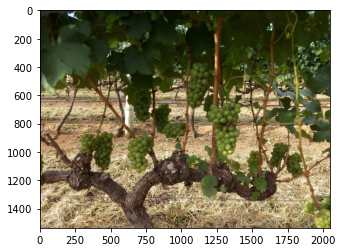

In [36]:
plt.imshow(images[idimg].permute(1,2,0).cpu().numpy())

In [37]:
model2.eval()
cpu_device = torch.device("cpu")

outputs22 = model2(images)
outputs22 = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs22]

In [38]:
z2= outputs22[idimg]

sample22 = images[idimg].permute(1,2,0).cpu().numpy()
boxes22 = z2['boxes'].detach().cpu().numpy().astype(np.int32)

In [39]:
sample42 = images[idimg].permute(1,2,0).cpu().numpy()
boxes42 = targets[idimg]['boxes'].cpu().numpy().astype(np.int32)

## Predição do modelo (esquerda) e anotações manuais (direita)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


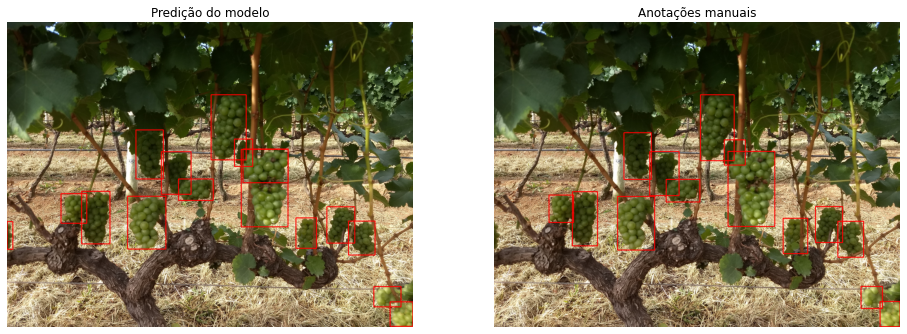

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

s1=sample22.copy()
s2=sample42.copy()
for box in boxes22:
    cv2.rectangle(s1,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

for box in boxes42:
    cv2.rectangle(s2,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax[0].set_title('Predição do modelo')
ax[1].set_title('Anotações manuais')
ax[0].set_axis_off()
ax[0].imshow(s1)
ax[1].set_axis_off()
ax[1].imshow(s2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


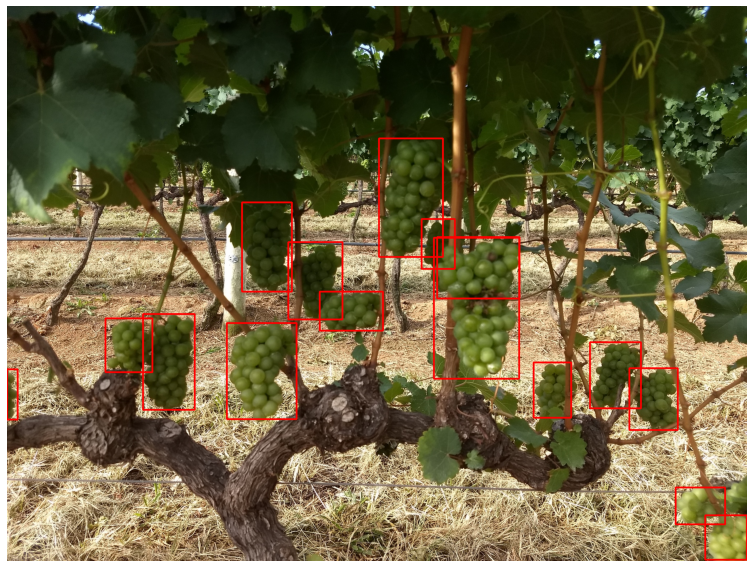

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

s1=sample22.copy()

for box in boxes22:
    cv2.rectangle(s1,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
cv2.imwrite("pred.png", cv2.cvtColor(s1, cv2.COLOR_BGR2RGB))    
plt.axis("off")
plt.imshow(s1)
plt.tight_layout()
plt.savefig("predicao.png", dpi=fig.dpi) 
plt.show()


In [42]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', '1'
]

In [43]:
pred_class22 = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(outputs22[idimg]['labels'].numpy())] 
  
print(pred_class22) 

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


In [44]:
outputs22

[{'boxes': tensor([[1613.6517,  930.6729, 1754.3529, 1113.5271],
          [1722.8213, 1002.1445, 1856.4865, 1173.4827],
          [ 376.4166,  852.3199,  519.5736, 1117.7449],
          [ 865.9452,  790.5837, 1040.0319,  898.2159],
          [ 778.7038,  653.1079,  928.9926,  867.0748],
          [ 608.4034,  877.9965,  801.3552, 1143.4595],
          [1029.9417,  366.8984, 1206.2164,  694.5897],
          [ 650.6890,  543.4665,  788.9367,  790.2139],
          [1932.1190, 1409.5089, 2047.7971, 1532.1331],
          [1457.9510,  986.3010, 1561.8772, 1139.9834],
          [ 272.6451,  864.5189,  402.3576, 1013.4504],
          [1147.9966,  589.0183, 1239.2213,  727.6848],
          [1181.3854,  641.2639, 1417.7734, 1031.9960],
          [1850.4232, 1332.7692, 1987.1105, 1434.4247],
          [1190.2716,  639.6859, 1418.2434,  809.8814],
          [   0.0000, 1005.9313,   29.8478, 1144.2999]], grad_fn=<CopyBackwards>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [45]:
z2['scores'].detach().cpu().numpy().astype(np.float32)

array([0.9997135 , 0.99966586, 0.9996014 , 0.99953735, 0.9995216 ,
       0.9994141 , 0.9993975 , 0.9993799 , 0.99917185, 0.9989415 ,
       0.998777  , 0.9964887 , 0.9959585 , 0.99034077, 0.96752334,
       0.3236992 ], dtype=float32)

## Teste scores

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


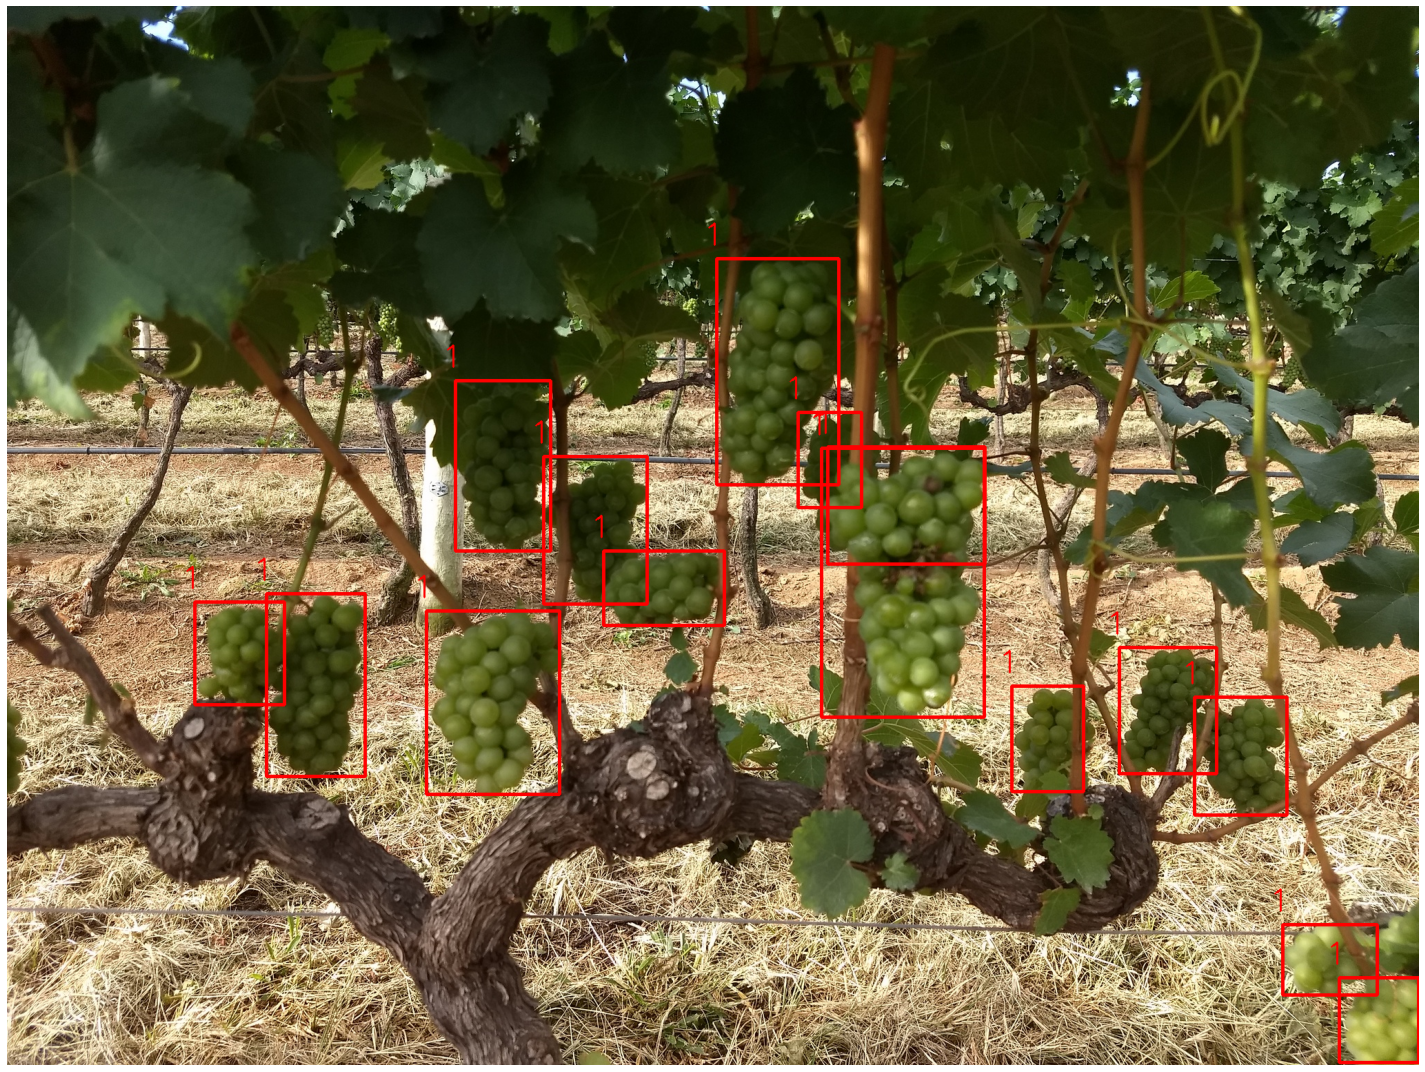

In [46]:
base_scores = pd.DataFrame(boxes22)
base_scores.rename(columns={0:"x",1:"y",2:"w",3:"h"}, inplace=True)

base_scores['label'] = pred_class22
base_scores[['x', 'y', 'w', 'h']].iloc[0].to_numpy()
base_scores['scores'] = z2['scores'].detach().cpu().numpy().astype(np.float32)
data_score = base_scores[base_scores['scores'] > 0.6]
res_score = data_score[['x', 'y', 'w', 'h']].to_numpy(dtype="Int64")

s1=sample22.copy()
fig, ax = plt.subplots(1, 1, figsize=(int(s1.shape[1]/100),int(s1.shape[0]/100)))

s2=sample42.copy()
cont= 0
for box in res_score:
    cv2.rectangle(s1,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = data_score['label'].iloc[cont]
    # Meaning of 7 parameters (picture, text information, placement position, font, font size, font color, thickness)
    cv2.putText(s1, text, (int(box[0])-20, int(box[1]-20)), font, 1.5, (255,0,0), 2)
    cont = cont + 1
ax.set_axis_off()
ax.imshow(s1)
plt.tight_layout()
plt.savefig('predicao_score.png', dpi=fig.dpi)

In [47]:
from collections import Counter

 

predicted_classes = dict(Counter(pred_class22))
actual_classes = dict(Counter(targets[idimg]['labels'].tolist()))

 

for key, value in predicted_classes.items():
    print('\n Valores preditos para classe ',key, '->', value)
    if int(key) in actual_classes:
        print(' Valores reais para classe', key, '->', actual_classes[int(key)])


 Valores preditos para classe  1 -> 16
 Valores reais para classe 1 -> 14


In [48]:
s = list()
s.append(float(4))
list(predicted_classes.items())

[('1', 16)]